In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.8.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# define  dataset tho

In [2]:
import json
import os
import os.path as osp
from typing import Callable, List, Optional, Union

import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from torch_geometric.io import fs, read_txt_array


class BreakBad(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {
        'Statue_0': '101902_sf',
        'Statue_1': '102068_sf',
        'Statue_2': '103538_sf',
        'Statue_3': '103737_sf',
        'Statue_4': '104442_sf',
        'Statue_5': '108010_sf',
        'Statue_6': '120477_sf',
        'Statue_7': '120628_sf',

    }



    seg_classes = {
        'Statue_0': [0,1],
        'Statue_1': [2,3],
        'Statue_2': [4,5],
        'Statue_3': [6,7],
        'Statue_4': [8,9],
        'Statue_5': [10,11],
        'Statue_6': [12,13],
        'Statue_7': [14,15],
    }

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {
        '101902_sf' : 0,
        '102068_sf' : 1,
        '103538_sf' : 2,
        '103737_sf' : 3,
        '104442_sf' : 4,
        '108010_sf' : 5,
        '120477_sf' : 6,
        '120628_sf' : 7,

        }
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [3]:
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv


import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, knn_interpolate
from torch_geometric.typing import WITH_TORCH_CLUSTER
from torch_geometric.utils import scatter


In [4]:
!unzip /content/shapenet_withnormal_filtered.zip -d /content/temp_extract
!mkdir /content/data
!mkdir /content/data/raw
!mv /content/temp_extract/shapenet_withnormal_filtered/* /content/data/raw
!rm -r /content/temp_extract

Archive:  /content/shapenet_withnormal_filtered.zip
   creating: /content/temp_extract/shapenet_withnormal_filtered/
   creating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_20.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_22.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_40.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_41.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_46.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_59.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_70.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_72.txt  


In [5]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset = BreakBad(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset = BreakBad(path, category, split='test',
                        pre_transform=pre_transform)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False,
                         num_workers=2)

['Statue_0', 'Statue_1', 'Statue_2', 'Statue_3', 'Statue_4', 'Statue_5', 'Statue_6', 'Statue_7']


Processing...


['Statue_0', 'Statue_1', 'Statue_2', 'Statue_3', 'Statue_4', 'Statue_5', 'Statue_6', 'Statue_7']


Done!


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import torch
import random
import numpy as np

gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])

@torch.no_grad()
def visualize_ground_truth_3d(loader, num_samples=4):
    # Load all data samples into a list for random access
    all_data = list(loader)

    sampled_data = random.sample(all_data, min(num_samples, len(all_data)))
    sample_id = 1

    for data in sampled_data:
        data = data.to(device)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)
        ys = data.y.split(sizes)

        for x, y in zip(xs, ys):
            x_np = x.cpu().numpy()
            y_np = y.cpu().numpy()

            # Convert y labels to RGB colors using gt_cmap
            colors = gt_cmap[y_np%2]
            print(f"Unique classes {np.unique(y_np)}")
            fig = plt.figure(figsize=(6, 5))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(x_np[:, 0], x_np[:, 1], x_np[:, 2], c=colors, s=5)
            ax.set_title(f'Ground Truth - Sample {sample_id}')
            ax.set_axis_off()
            plt.tight_layout()
            plt.show()

            sample_id += 1
            if sample_id > num_samples:
                return


Unique classes [10 11]


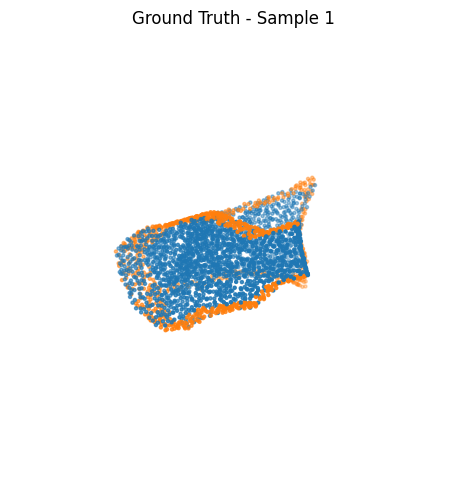

Unique classes [4 5]


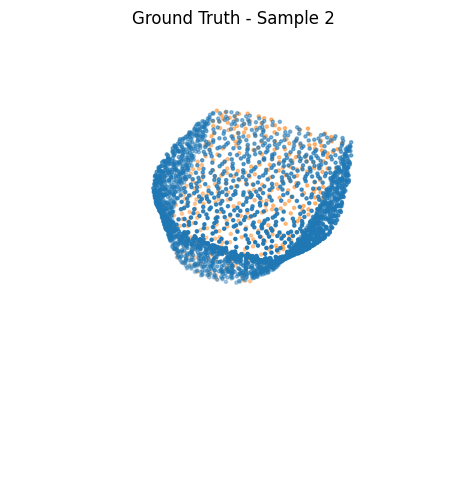

Unique classes [6 7]


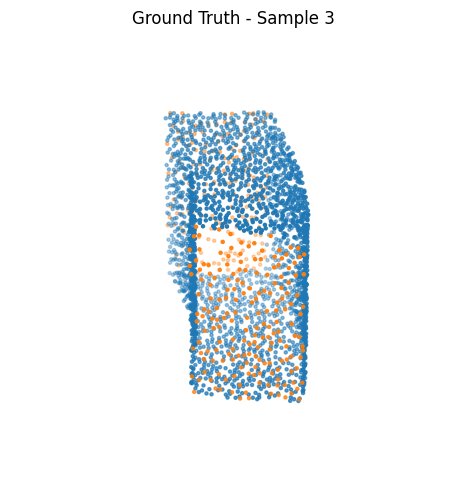

Unique classes [4 5]


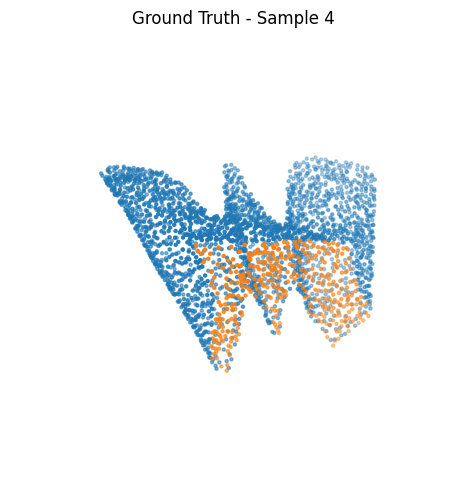

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_ground_truth_3d(test_loader, num_samples=4)

# RanlaNet

In [9]:

class Net(torch.nn.Module):
    def __init__(self, out_channels, k=30, aggr='max'):
        super().__init__()

        self.conv1 = DynamicEdgeConv(MLP([2 * 6, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 64, 64]), k, aggr)
        self.conv3 = DynamicEdgeConv(MLP([2 * 64, 64, 64]), k, aggr)

        self.mlp = MLP([3 * 64, 1024, 256, 128, out_channels], dropout=0.5,
                       norm=None)

    def forward(self, data):
        x, pos, batch = data.x, data.pos, data.batch
        x0 = torch.cat([x, pos], dim=-1)
        x1 = self.conv1(x0, batch)
        x2 = self.conv2(x1, batch)
        x3 = self.conv3(x2, batch)
        out = self.mlp(torch.cat([x1, x2, x3], dim=1))
        return F.log_softmax(out, dim=1)


In [10]:
def jaccard_index(pred: torch.Tensor, target: torch.Tensor, num_classes: int, absent_score: float = 1.0) -> float:
    """
    Compute mean Intersection over Union (IoU) between predicted and target labels.

    Args:
        pred (Tensor): Predicted labels (1D tensor of shape [N]).
        target (Tensor): Ground truth labels (1D tensor of shape [N]).
        num_classes (int): Number of classes to consider (usually the number of part labels for a category).
        absent_score (float): Score to assign if a class is absent in both pred and target.

    Returns:
        float: Mean IoU over classes.
    """
    device = pred.device
    ious = []

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()

        if union == 0:
            iou = torch.tensor(absent_score, device=device)
        else:
            iou = intersection.float() / union.float()
        ious.append(iou)

    # Stack and compute mean
    return torch.stack(ious).mean().item()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(train_dataset.num_classes, k=30).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)


[10/183] Loss: 2.0868 Train Acc: 0.3208
[20/183] Loss: 2.1203 Train Acc: 0.3265
[30/183] Loss: 1.9838 Train Acc: 0.3559
[40/183] Loss: 1.9840 Train Acc: 0.3694
[50/183] Loss: 1.7433 Train Acc: 0.4333
[60/183] Loss: 1.7869 Train Acc: 0.4224
[70/183] Loss: 1.8866 Train Acc: 0.3846
[80/183] Loss: 1.7906 Train Acc: 0.4071
[90/183] Loss: 1.7191 Train Acc: 0.4414
[100/183] Loss: 1.7802 Train Acc: 0.3986
[110/183] Loss: 1.6951 Train Acc: 0.4427
[120/183] Loss: 1.5986 Train Acc: 0.4860
[130/183] Loss: 1.6989 Train Acc: 0.4491
[140/183] Loss: 1.7624 Train Acc: 0.4282
[150/183] Loss: 1.6376 Train Acc: 0.4630
[160/183] Loss: 1.6355 Train Acc: 0.4676
[170/183] Loss: 1.6475 Train Acc: 0.4659
[180/183] Loss: 1.5572 Train Acc: 0.4782
Epoch: 01, Test IoU: 0.8176


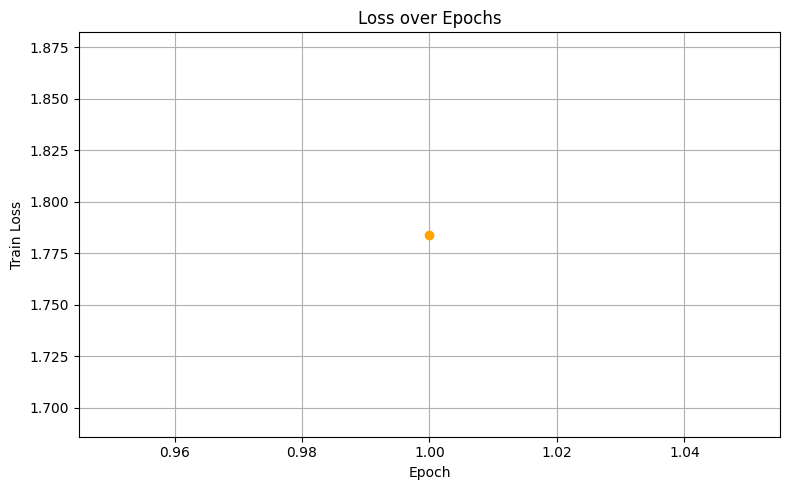

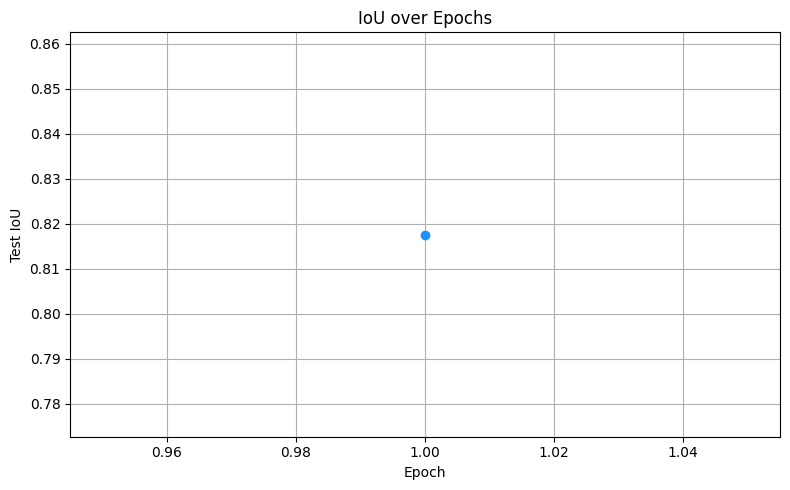

  >> Best model saved at epoch 1 with IoU: 0.8176
[10/183] Loss: 1.5825 Train Acc: 0.5097
[20/183] Loss: 1.5661 Train Acc: 0.5022
[30/183] Loss: 1.7085 Train Acc: 0.3963
[40/183] Loss: 1.6125 Train Acc: 0.4583
[50/183] Loss: 1.5178 Train Acc: 0.5045
[60/183] Loss: 1.6245 Train Acc: 0.4410
[70/183] Loss: 1.5503 Train Acc: 0.5069
[80/183] Loss: 1.5067 Train Acc: 0.5078
[90/183] Loss: 1.4747 Train Acc: 0.4898
[100/183] Loss: 1.5026 Train Acc: 0.5021
[110/183] Loss: 1.4251 Train Acc: 0.5160
[120/183] Loss: 1.4796 Train Acc: 0.4951
[130/183] Loss: 1.4331 Train Acc: 0.5035
[140/183] Loss: 1.4502 Train Acc: 0.5196
[150/183] Loss: 1.4444 Train Acc: 0.5063
[160/183] Loss: 1.4450 Train Acc: 0.4900
[170/183] Loss: 1.4435 Train Acc: 0.4912
[180/183] Loss: 1.4483 Train Acc: 0.5139
Epoch: 02, Test IoU: 0.8812


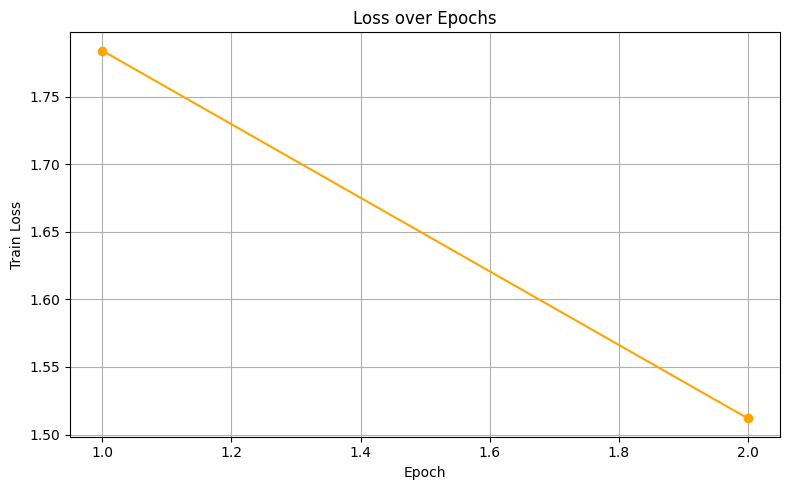

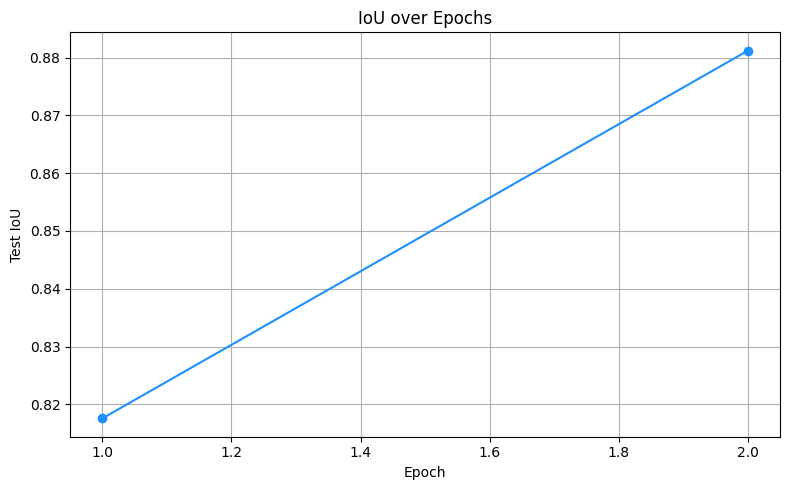

  >> Best model saved at epoch 2 with IoU: 0.8812
[10/183] Loss: 1.4019 Train Acc: 0.5033
[20/183] Loss: 1.4240 Train Acc: 0.4922
[30/183] Loss: 1.4535 Train Acc: 0.5033
[40/183] Loss: 1.3207 Train Acc: 0.5567
[50/183] Loss: 1.3720 Train Acc: 0.5317
[60/183] Loss: 1.4319 Train Acc: 0.5148
[70/183] Loss: 1.4012 Train Acc: 0.5239
[80/183] Loss: 1.3380 Train Acc: 0.5296
[90/183] Loss: 1.2546 Train Acc: 0.5781
[100/183] Loss: 1.2187 Train Acc: 0.5661
[110/183] Loss: 1.2862 Train Acc: 0.5625
[120/183] Loss: 1.4126 Train Acc: 0.5151
[130/183] Loss: 1.2940 Train Acc: 0.5552
[140/183] Loss: 1.3628 Train Acc: 0.5237
[150/183] Loss: 1.3957 Train Acc: 0.5128
[160/183] Loss: 1.3212 Train Acc: 0.5454
[170/183] Loss: 1.3382 Train Acc: 0.5422
[180/183] Loss: 1.2155 Train Acc: 0.5919
Epoch: 03, Test IoU: 0.8883


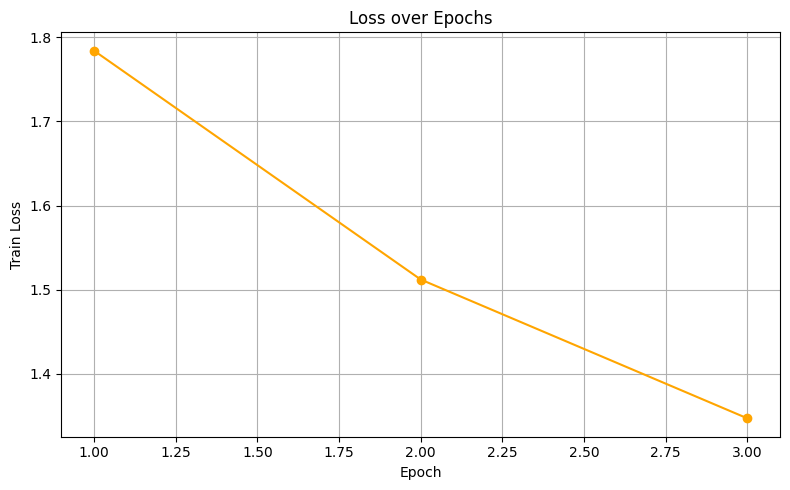

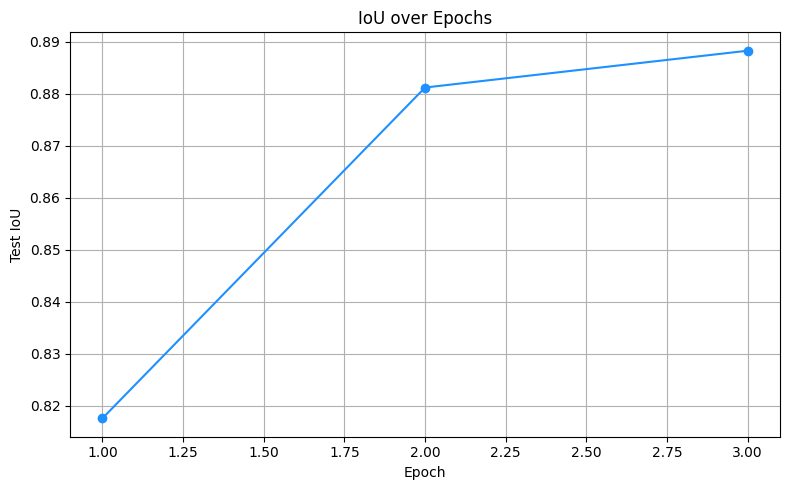

  >> Best model saved at epoch 3 with IoU: 0.8883
[10/183] Loss: 1.2669 Train Acc: 0.5504
[20/183] Loss: 1.2360 Train Acc: 0.5839
[30/183] Loss: 1.2903 Train Acc: 0.5449
[40/183] Loss: 1.1836 Train Acc: 0.5980
[50/183] Loss: 1.1509 Train Acc: 0.5943
[60/183] Loss: 1.3424 Train Acc: 0.5265
[70/183] Loss: 1.1915 Train Acc: 0.5808
[80/183] Loss: 1.1913 Train Acc: 0.5663
[90/183] Loss: 1.1349 Train Acc: 0.5990
[100/183] Loss: 1.2473 Train Acc: 0.5522
[110/183] Loss: 1.2586 Train Acc: 0.5753
[120/183] Loss: 1.1651 Train Acc: 0.5825
[130/183] Loss: 1.1899 Train Acc: 0.5962
[140/183] Loss: 1.1295 Train Acc: 0.6184
[150/183] Loss: 1.1802 Train Acc: 0.5916
[160/183] Loss: 1.2274 Train Acc: 0.5605
[170/183] Loss: 1.1789 Train Acc: 0.5937
[180/183] Loss: 1.0047 Train Acc: 0.6481
Epoch: 04, Test IoU: 0.9059


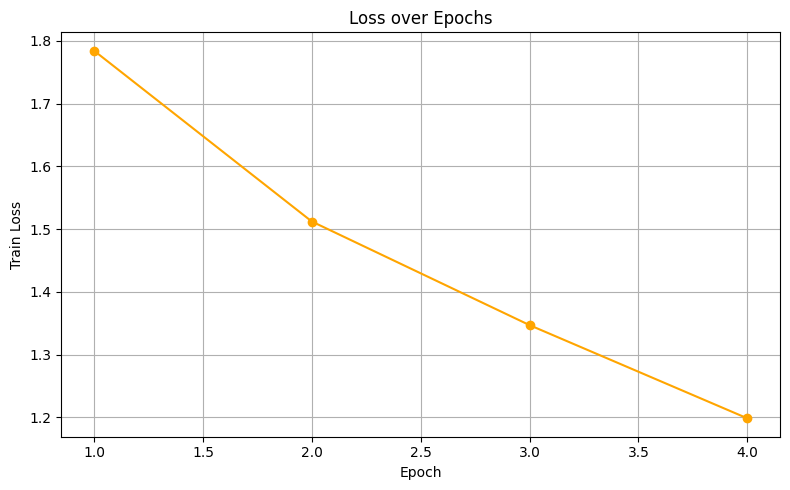

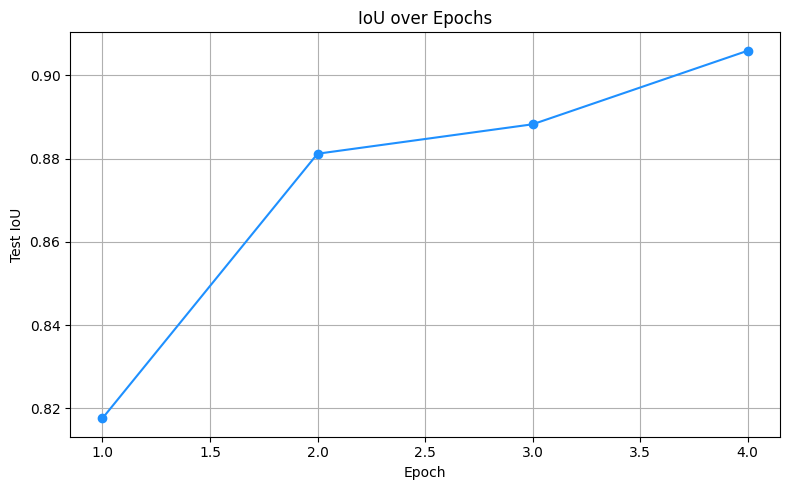

  >> Best model saved at epoch 4 with IoU: 0.9059
[10/183] Loss: 1.1145 Train Acc: 0.5994
[20/183] Loss: 1.1316 Train Acc: 0.6041
[30/183] Loss: 1.0488 Train Acc: 0.6323
[40/183] Loss: 1.2721 Train Acc: 0.5570
[50/183] Loss: 1.0914 Train Acc: 0.6060
[60/183] Loss: 1.2293 Train Acc: 0.5548
[70/183] Loss: 1.2051 Train Acc: 0.5799
[80/183] Loss: 1.2137 Train Acc: 0.5659
[90/183] Loss: 1.0453 Train Acc: 0.6348
[100/183] Loss: 1.1622 Train Acc: 0.5953
[110/183] Loss: 1.1415 Train Acc: 0.6120
[120/183] Loss: 1.1298 Train Acc: 0.6041
[130/183] Loss: 1.1518 Train Acc: 0.5925
[140/183] Loss: 1.1891 Train Acc: 0.5740
[150/183] Loss: 1.2289 Train Acc: 0.5541
[160/183] Loss: 1.1661 Train Acc: 0.5808
[170/183] Loss: 1.1752 Train Acc: 0.5745
[180/183] Loss: 1.0898 Train Acc: 0.6279
Epoch: 05, Test IoU: 0.9162


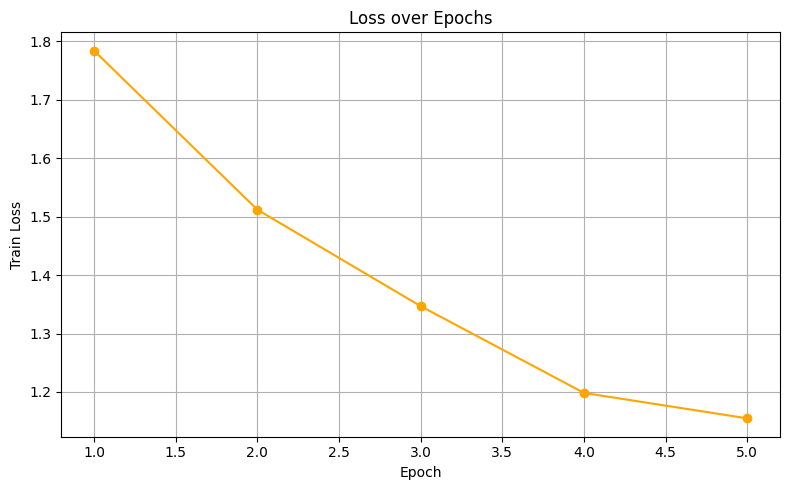

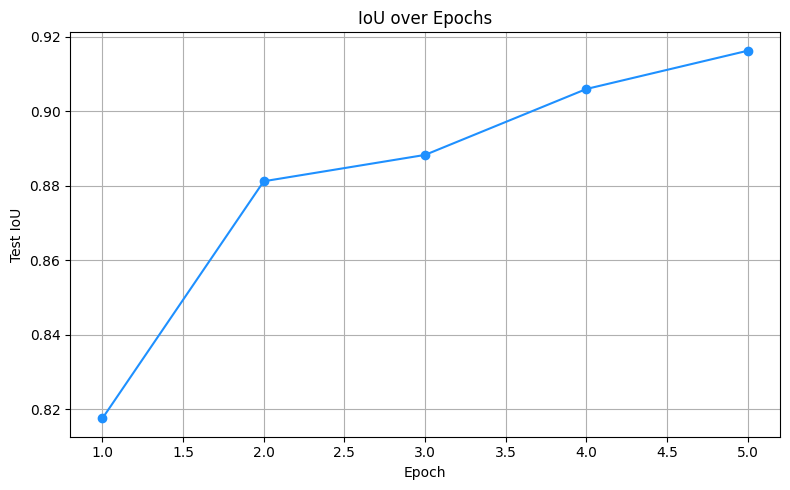

  >> Best model saved at epoch 5 with IoU: 0.9162
[10/183] Loss: 0.9933 Train Acc: 0.6496
[20/183] Loss: 1.1764 Train Acc: 0.5790
[30/183] Loss: 0.9833 Train Acc: 0.6563
[40/183] Loss: 1.1146 Train Acc: 0.6144
[50/183] Loss: 1.0757 Train Acc: 0.6118
[60/183] Loss: 1.1317 Train Acc: 0.5962
[70/183] Loss: 0.9552 Train Acc: 0.6727
[80/183] Loss: 1.0637 Train Acc: 0.6374
[90/183] Loss: 1.1513 Train Acc: 0.5906
[100/183] Loss: 1.0496 Train Acc: 0.6307
[110/183] Loss: 0.9835 Train Acc: 0.6459
[120/183] Loss: 1.1259 Train Acc: 0.6282
[130/183] Loss: 1.0953 Train Acc: 0.6125
[140/183] Loss: 1.1406 Train Acc: 0.5880
[150/183] Loss: 1.0649 Train Acc: 0.6265
[160/183] Loss: 1.1450 Train Acc: 0.5779
[170/183] Loss: 1.0722 Train Acc: 0.6334
[180/183] Loss: 1.0694 Train Acc: 0.6168
Epoch: 06, Test IoU: 0.9247


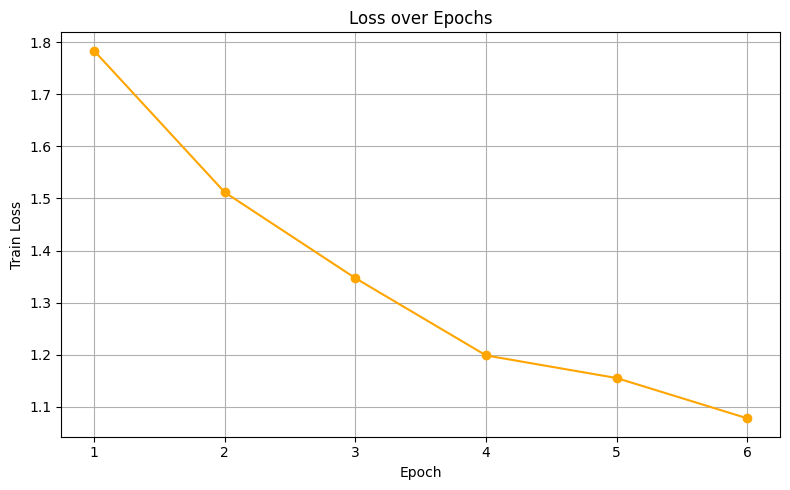

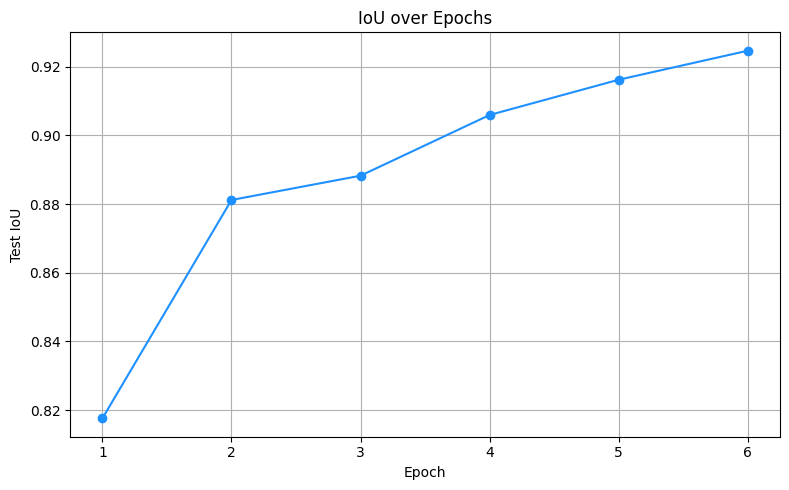

  >> Best model saved at epoch 6 with IoU: 0.9247
[10/183] Loss: 1.1412 Train Acc: 0.5915
[20/183] Loss: 1.0574 Train Acc: 0.6241
[30/183] Loss: 1.0576 Train Acc: 0.6257
[40/183] Loss: 1.0456 Train Acc: 0.6255
[50/183] Loss: 1.0580 Train Acc: 0.6336
[60/183] Loss: 1.0547 Train Acc: 0.6426
[70/183] Loss: 1.0836 Train Acc: 0.6178
[80/183] Loss: 1.0608 Train Acc: 0.6192
[90/183] Loss: 1.0881 Train Acc: 0.6037
[100/183] Loss: 0.9866 Train Acc: 0.6513
[110/183] Loss: 1.1087 Train Acc: 0.6106
[120/183] Loss: 0.9251 Train Acc: 0.6734
[130/183] Loss: 0.9338 Train Acc: 0.6803
[140/183] Loss: 0.9634 Train Acc: 0.6566
[150/183] Loss: 0.9992 Train Acc: 0.6375
[160/183] Loss: 0.9538 Train Acc: 0.6586
[170/183] Loss: 1.0507 Train Acc: 0.6169
[180/183] Loss: 1.0809 Train Acc: 0.6158
Epoch: 07, Test IoU: 0.9253


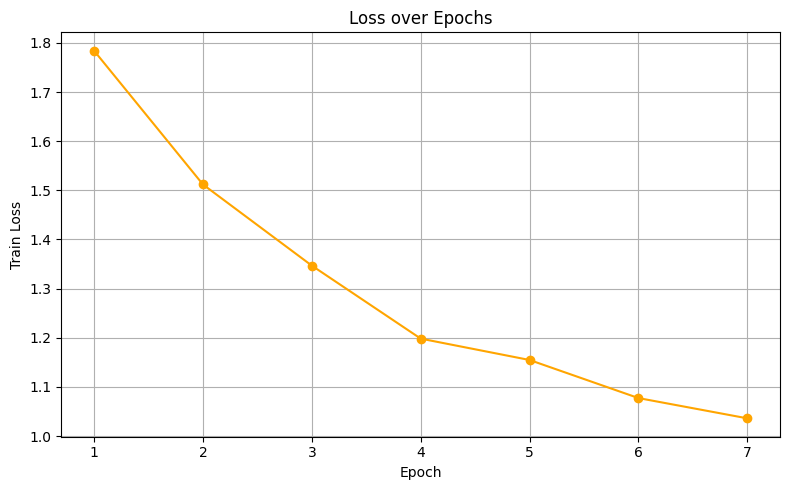

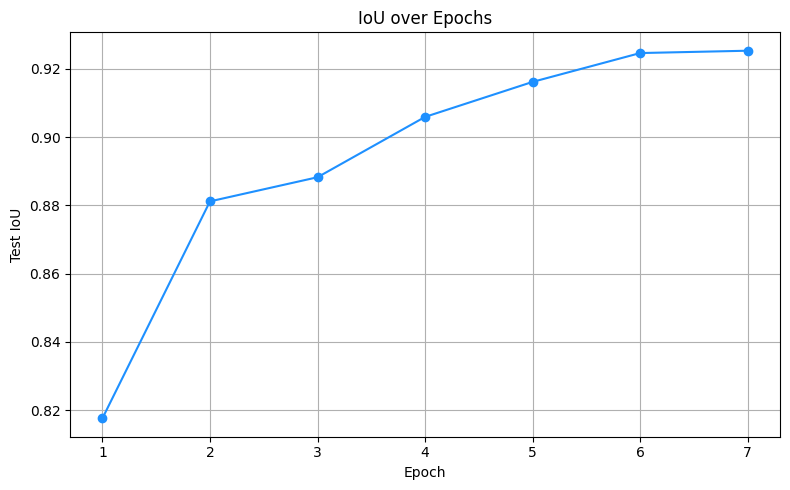

  >> Best model saved at epoch 7 with IoU: 0.9253
[10/183] Loss: 1.0038 Train Acc: 0.6494
[20/183] Loss: 0.9785 Train Acc: 0.6498
[30/183] Loss: 1.0153 Train Acc: 0.6288
[40/183] Loss: 1.0169 Train Acc: 0.6510
[50/183] Loss: 1.0411 Train Acc: 0.6437
[60/183] Loss: 1.0273 Train Acc: 0.6380
[70/183] Loss: 0.9481 Train Acc: 0.6692
[80/183] Loss: 0.9537 Train Acc: 0.6651
[90/183] Loss: 0.9838 Train Acc: 0.6358
[100/183] Loss: 0.8528 Train Acc: 0.7009
[110/183] Loss: 1.0068 Train Acc: 0.6710
[120/183] Loss: 1.1675 Train Acc: 0.5892
[130/183] Loss: 1.0462 Train Acc: 0.6344
[140/183] Loss: 1.0252 Train Acc: 0.6381
[150/183] Loss: 1.0886 Train Acc: 0.6031
[160/183] Loss: 0.9611 Train Acc: 0.6477
[170/183] Loss: 0.9233 Train Acc: 0.6831
[180/183] Loss: 0.9709 Train Acc: 0.6541
Epoch: 08, Test IoU: 0.9315


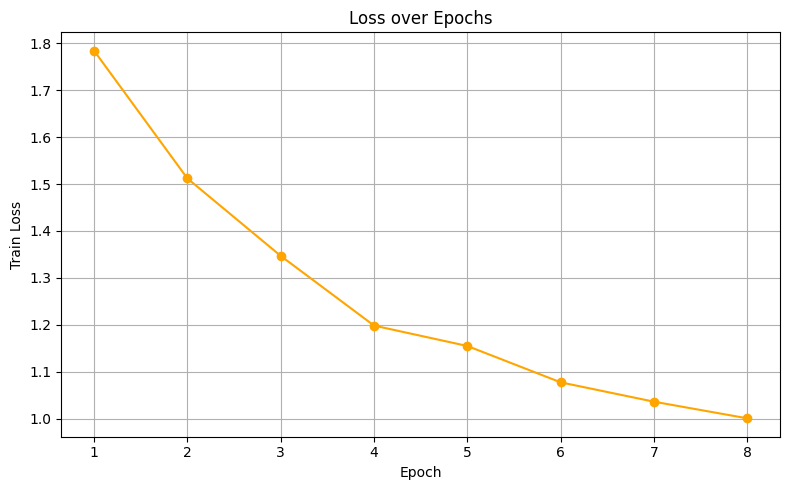

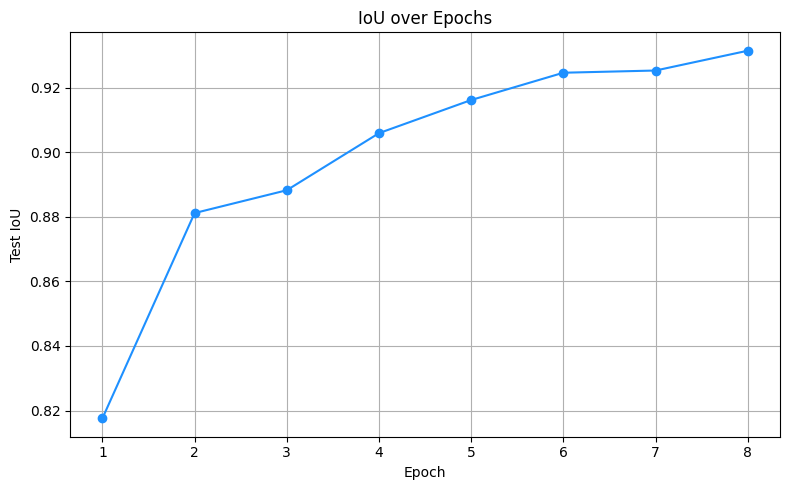

  >> Best model saved at epoch 8 with IoU: 0.9315
[10/183] Loss: 0.9800 Train Acc: 0.6700
[20/183] Loss: 0.9121 Train Acc: 0.6807
[30/183] Loss: 0.9705 Train Acc: 0.6426
[40/183] Loss: 0.9394 Train Acc: 0.6648
[50/183] Loss: 0.9706 Train Acc: 0.6364
[60/183] Loss: 0.8942 Train Acc: 0.6808
[70/183] Loss: 0.8959 Train Acc: 0.6834
[80/183] Loss: 0.9172 Train Acc: 0.6702
[90/183] Loss: 0.9802 Train Acc: 0.6375
[100/183] Loss: 1.0553 Train Acc: 0.6175
[110/183] Loss: 1.0174 Train Acc: 0.6521
[120/183] Loss: 1.0430 Train Acc: 0.6412
[130/183] Loss: 1.0927 Train Acc: 0.6304
[140/183] Loss: 0.9913 Train Acc: 0.6404
[150/183] Loss: 1.0329 Train Acc: 0.6416
[160/183] Loss: 0.8307 Train Acc: 0.7209
[170/183] Loss: 0.9718 Train Acc: 0.6570
[180/183] Loss: 0.9632 Train Acc: 0.6684
Epoch: 09, Test IoU: 0.9327


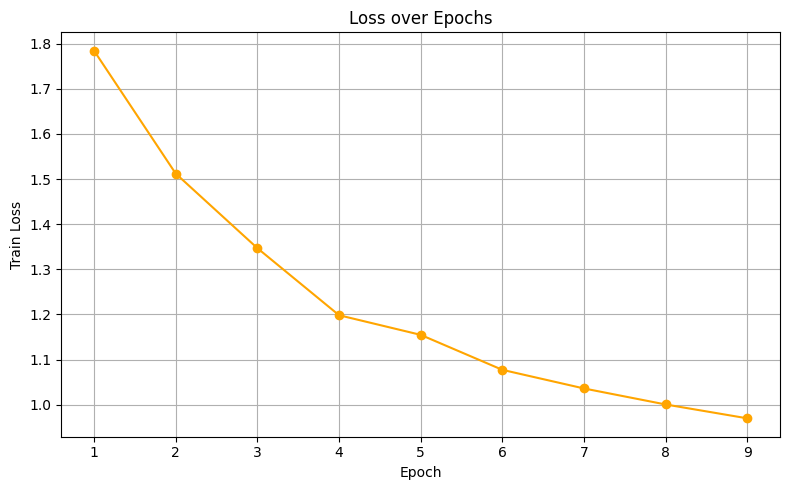

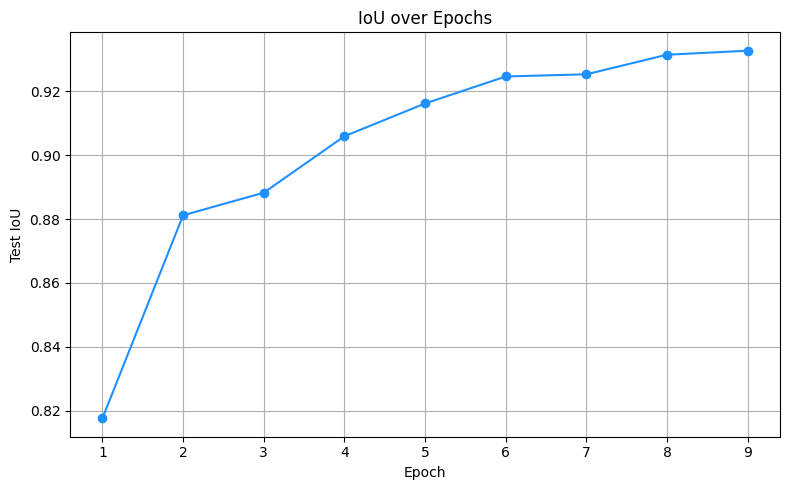

  >> Best model saved at epoch 9 with IoU: 0.9327
[10/183] Loss: 1.0098 Train Acc: 0.6469
[20/183] Loss: 0.9770 Train Acc: 0.6503
[30/183] Loss: 0.9634 Train Acc: 0.6404
[40/183] Loss: 0.9067 Train Acc: 0.6745
[50/183] Loss: 0.8988 Train Acc: 0.6836
[60/183] Loss: 0.8104 Train Acc: 0.7208
[70/183] Loss: 0.8604 Train Acc: 0.7042
[80/183] Loss: 0.8987 Train Acc: 0.6690
[90/183] Loss: 0.8793 Train Acc: 0.6890
[100/183] Loss: 0.8974 Train Acc: 0.6813
[110/183] Loss: 0.8899 Train Acc: 0.6830
[120/183] Loss: 0.9232 Train Acc: 0.6764
[130/183] Loss: 0.8956 Train Acc: 0.6926
[140/183] Loss: 0.9357 Train Acc: 0.6775
[150/183] Loss: 0.9101 Train Acc: 0.6878
[160/183] Loss: 0.8531 Train Acc: 0.7141
[170/183] Loss: 0.8952 Train Acc: 0.6879
[180/183] Loss: 1.1262 Train Acc: 0.5837
Epoch: 10, Test IoU: 0.9349


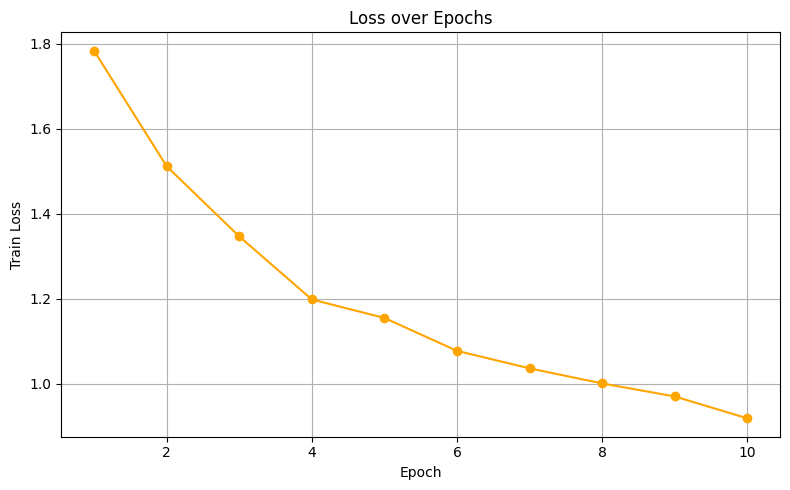

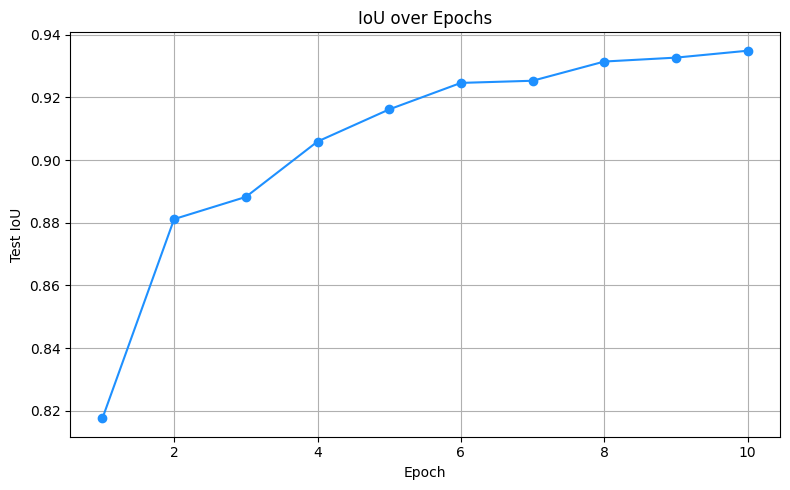

  >> Best model saved at epoch 10 with IoU: 0.9349
[10/183] Loss: 0.8370 Train Acc: 0.7129
[20/183] Loss: 0.9346 Train Acc: 0.6741
[30/183] Loss: 0.8749 Train Acc: 0.7012
[40/183] Loss: 0.8457 Train Acc: 0.6772
[50/183] Loss: 0.8774 Train Acc: 0.6883
[60/183] Loss: 0.8693 Train Acc: 0.7019
[70/183] Loss: 0.8757 Train Acc: 0.6989
[80/183] Loss: 0.8854 Train Acc: 0.7006
[90/183] Loss: 0.8053 Train Acc: 0.7183
[100/183] Loss: 0.8856 Train Acc: 0.6921
[110/183] Loss: 0.9390 Train Acc: 0.6708
[120/183] Loss: 1.0280 Train Acc: 0.6209
[130/183] Loss: 0.9180 Train Acc: 0.6702
[140/183] Loss: 0.8691 Train Acc: 0.6908
[150/183] Loss: 0.8869 Train Acc: 0.6837
[160/183] Loss: 1.0218 Train Acc: 0.6504
[170/183] Loss: 0.9399 Train Acc: 0.6748
[180/183] Loss: 0.8640 Train Acc: 0.6968
Epoch: 11, Test IoU: 0.9410


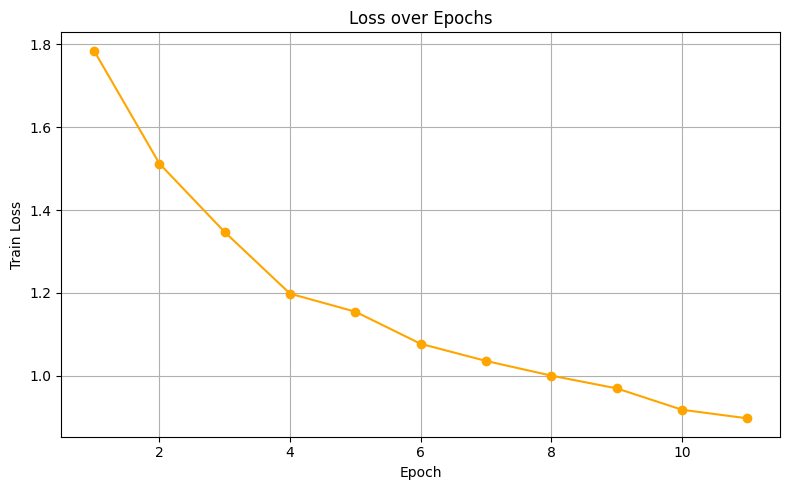

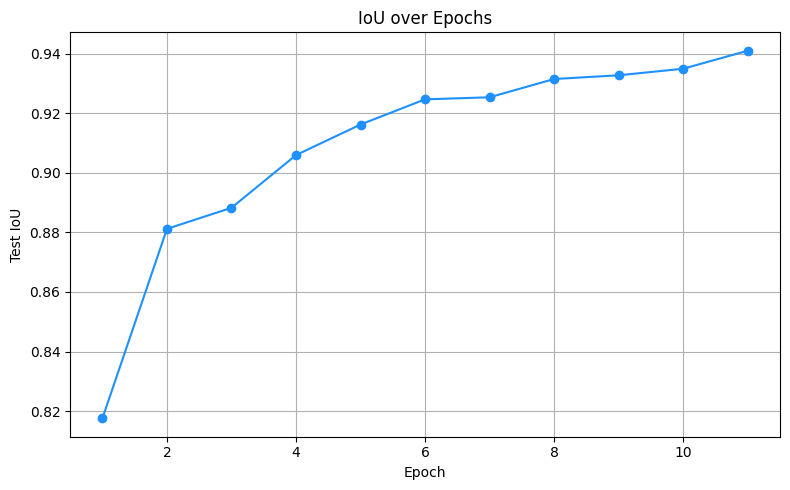

  >> Best model saved at epoch 11 with IoU: 0.9410
[10/183] Loss: 0.7981 Train Acc: 0.7234
[20/183] Loss: 0.8854 Train Acc: 0.6789
[30/183] Loss: 0.9483 Train Acc: 0.6613
[40/183] Loss: 0.9307 Train Acc: 0.6613
[50/183] Loss: 0.8847 Train Acc: 0.6824
[60/183] Loss: 0.8063 Train Acc: 0.7146
[70/183] Loss: 0.8116 Train Acc: 0.7335
[80/183] Loss: 0.8232 Train Acc: 0.7161
[90/183] Loss: 0.8927 Train Acc: 0.6876
[100/183] Loss: 0.8349 Train Acc: 0.6978
[110/183] Loss: 0.9409 Train Acc: 0.6622
[120/183] Loss: 0.8768 Train Acc: 0.6977
[130/183] Loss: 0.8960 Train Acc: 0.6937
[140/183] Loss: 0.9031 Train Acc: 0.6811
[150/183] Loss: 0.8534 Train Acc: 0.7150
[160/183] Loss: 0.8775 Train Acc: 0.6799
[170/183] Loss: 0.7865 Train Acc: 0.7181
[180/183] Loss: 0.8461 Train Acc: 0.6907
Epoch: 12, Test IoU: 0.9420


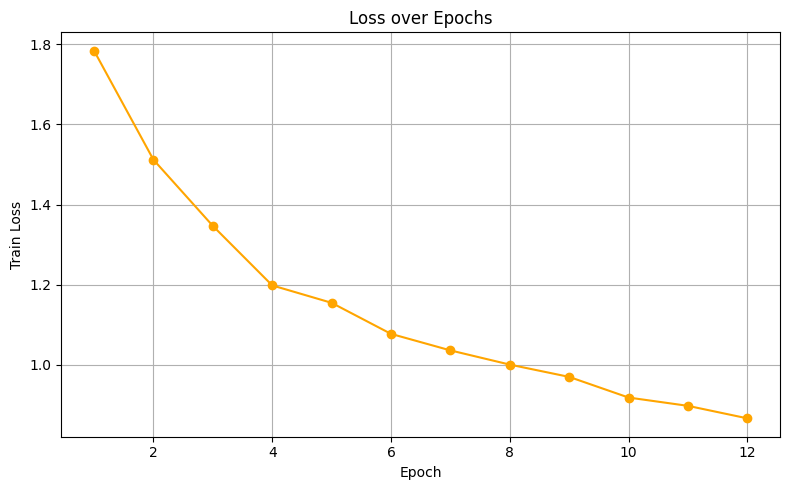

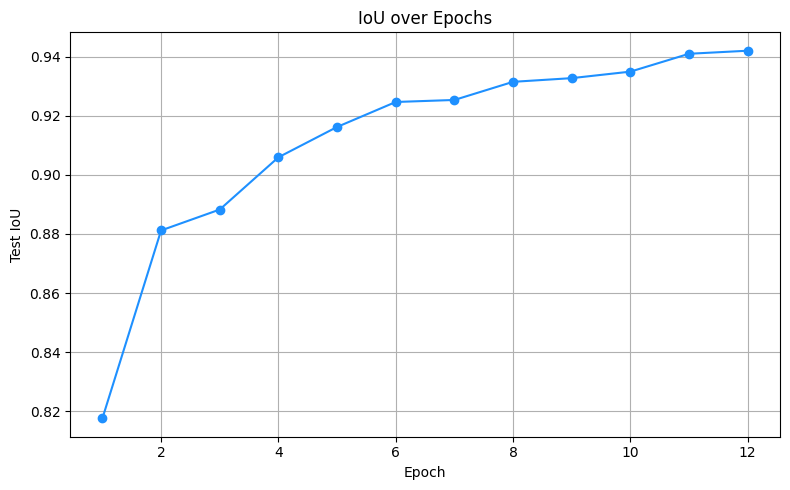

  >> Best model saved at epoch 12 with IoU: 0.9420
[10/183] Loss: 0.9026 Train Acc: 0.6786
[20/183] Loss: 0.8585 Train Acc: 0.7056
[30/183] Loss: 0.8400 Train Acc: 0.6951
[40/183] Loss: 0.8684 Train Acc: 0.6788
[50/183] Loss: 0.9274 Train Acc: 0.6692
[60/183] Loss: 0.8467 Train Acc: 0.6973
[70/183] Loss: 0.9285 Train Acc: 0.6735
[80/183] Loss: 0.9950 Train Acc: 0.6389
[90/183] Loss: 0.7827 Train Acc: 0.7242
[100/183] Loss: 0.7859 Train Acc: 0.7207
[110/183] Loss: 0.7073 Train Acc: 0.7547
[120/183] Loss: 0.7539 Train Acc: 0.7502
[130/183] Loss: 0.8632 Train Acc: 0.7019
[140/183] Loss: 0.7796 Train Acc: 0.7236
[150/183] Loss: 0.9007 Train Acc: 0.6805
[160/183] Loss: 0.7566 Train Acc: 0.7422
[170/183] Loss: 0.8282 Train Acc: 0.7129
[180/183] Loss: 0.8722 Train Acc: 0.6959
Epoch: 13, Test IoU: 0.9442


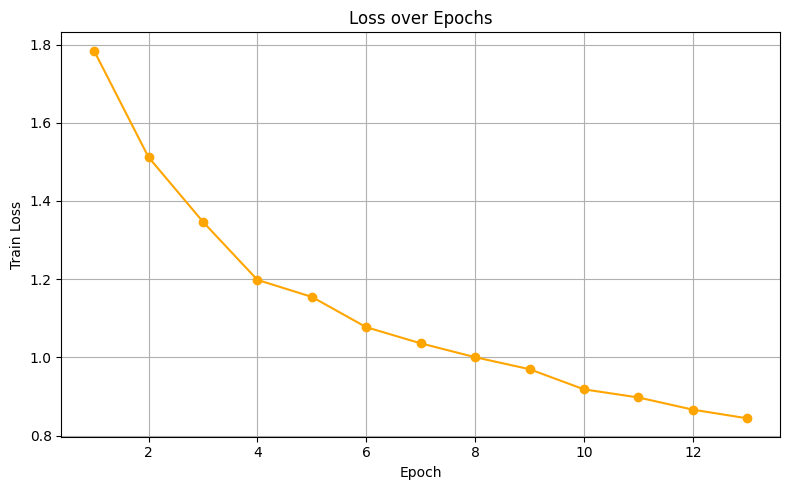

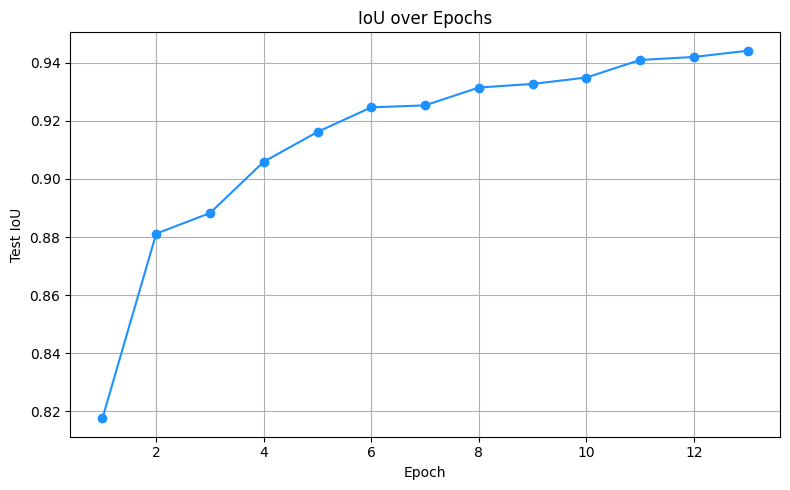

  >> Best model saved at epoch 13 with IoU: 0.9442
[10/183] Loss: 0.8874 Train Acc: 0.6744
[20/183] Loss: 0.7940 Train Acc: 0.7270
[30/183] Loss: 0.8580 Train Acc: 0.6914
[40/183] Loss: 0.7921 Train Acc: 0.7197
[50/183] Loss: 0.7799 Train Acc: 0.7164
[60/183] Loss: 0.8068 Train Acc: 0.7172
[70/183] Loss: 0.8354 Train Acc: 0.7153
[80/183] Loss: 0.7919 Train Acc: 0.7094
[90/183] Loss: 0.7868 Train Acc: 0.7207
[100/183] Loss: 0.8544 Train Acc: 0.6994
[110/183] Loss: 0.8147 Train Acc: 0.7186
[120/183] Loss: 0.8130 Train Acc: 0.7153
[130/183] Loss: 0.7714 Train Acc: 0.7269
[140/183] Loss: 0.8212 Train Acc: 0.7030
[150/183] Loss: 0.8777 Train Acc: 0.7043
[160/183] Loss: 0.7906 Train Acc: 0.7231
[170/183] Loss: 0.8356 Train Acc: 0.7070
[180/183] Loss: 0.8713 Train Acc: 0.6959
Epoch: 14, Test IoU: 0.9443


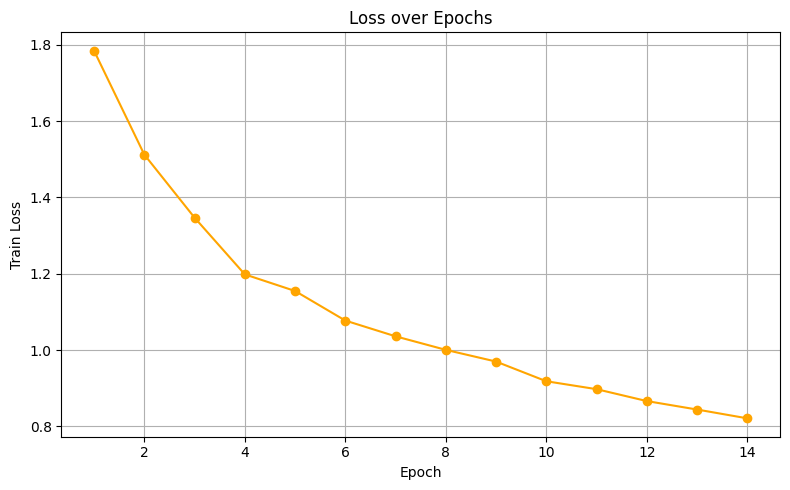

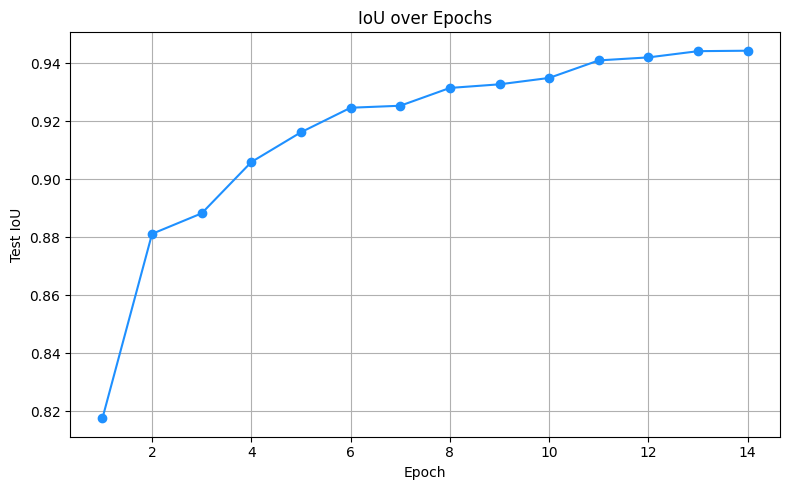

  >> Best model saved at epoch 14 with IoU: 0.9443
[10/183] Loss: 0.7840 Train Acc: 0.7249
[20/183] Loss: 0.7972 Train Acc: 0.7174
[30/183] Loss: 0.8408 Train Acc: 0.6995
[40/183] Loss: 0.9053 Train Acc: 0.6823
[50/183] Loss: 0.8442 Train Acc: 0.7137
[60/183] Loss: 0.7794 Train Acc: 0.7150
[70/183] Loss: 0.8378 Train Acc: 0.7167
[80/183] Loss: 0.7624 Train Acc: 0.7442
[90/183] Loss: 0.7920 Train Acc: 0.7320
[100/183] Loss: 0.8120 Train Acc: 0.7098
[110/183] Loss: 0.8781 Train Acc: 0.6761
[120/183] Loss: 0.6200 Train Acc: 0.7940
[130/183] Loss: 0.8254 Train Acc: 0.7103
[140/183] Loss: 0.8588 Train Acc: 0.6784
[150/183] Loss: 0.8250 Train Acc: 0.7063
[160/183] Loss: 0.8047 Train Acc: 0.7095
[170/183] Loss: 0.7980 Train Acc: 0.7268
[180/183] Loss: 0.7999 Train Acc: 0.7158
Epoch: 15, Test IoU: 0.9444


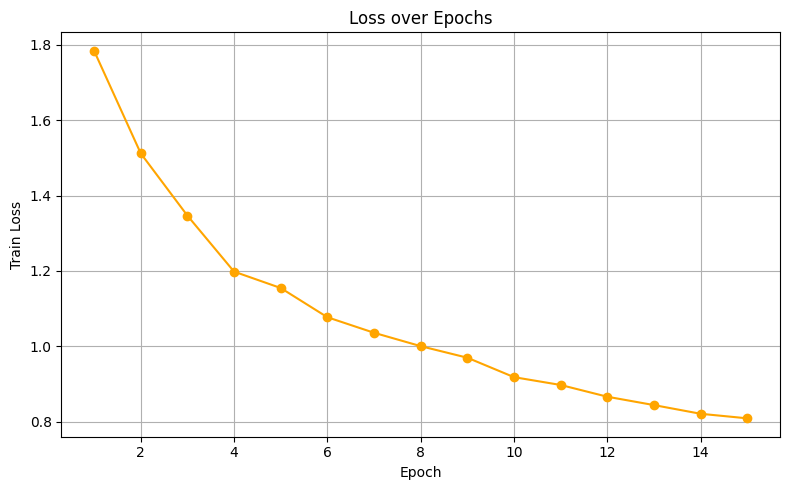

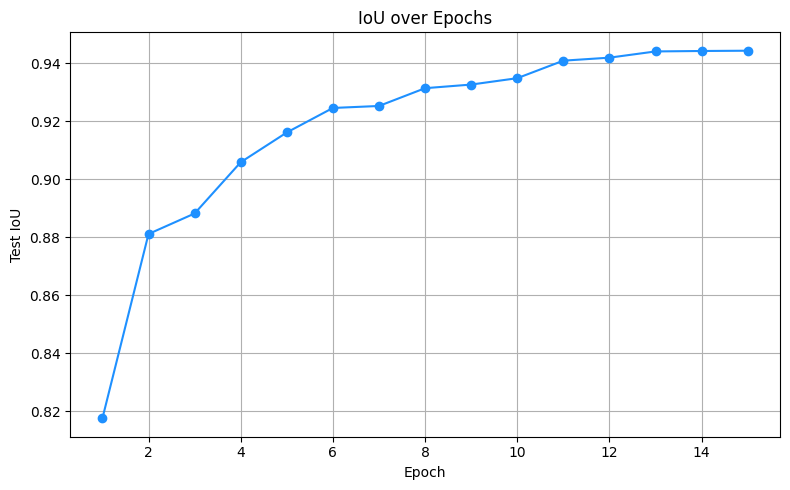

  >> Best model saved at epoch 15 with IoU: 0.9444
[10/183] Loss: 0.8076 Train Acc: 0.7060
[20/183] Loss: 0.7071 Train Acc: 0.7608
[30/183] Loss: 0.7458 Train Acc: 0.7420
[40/183] Loss: 0.8556 Train Acc: 0.6822
[50/183] Loss: 0.8278 Train Acc: 0.7046
[60/183] Loss: 0.7634 Train Acc: 0.7249
[70/183] Loss: 0.8004 Train Acc: 0.7155
[80/183] Loss: 0.8056 Train Acc: 0.7139
[90/183] Loss: 0.7490 Train Acc: 0.7471
[100/183] Loss: 0.8067 Train Acc: 0.7087
[110/183] Loss: 0.7059 Train Acc: 0.7429
[120/183] Loss: 0.6902 Train Acc: 0.7530
[130/183] Loss: 0.7995 Train Acc: 0.7139
[140/183] Loss: 0.7571 Train Acc: 0.7391
[150/183] Loss: 0.8267 Train Acc: 0.7228
[160/183] Loss: 0.7842 Train Acc: 0.7180
[170/183] Loss: 0.7465 Train Acc: 0.7386
[180/183] Loss: 0.7508 Train Acc: 0.7398
Epoch: 16, Test IoU: 0.9456


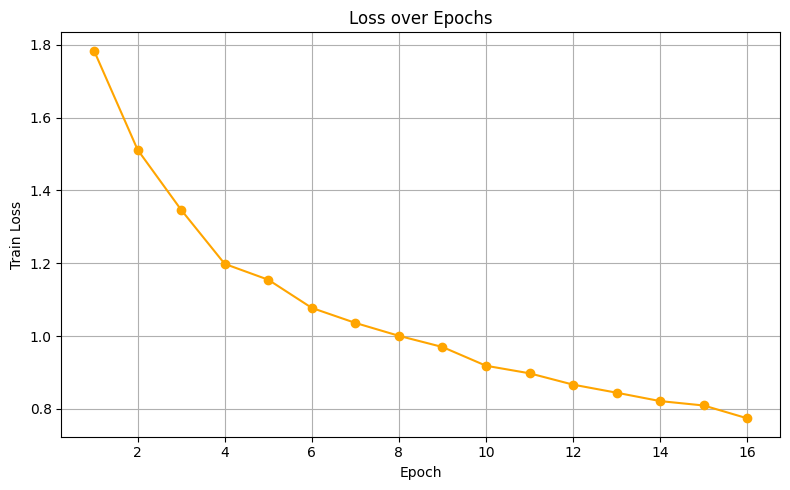

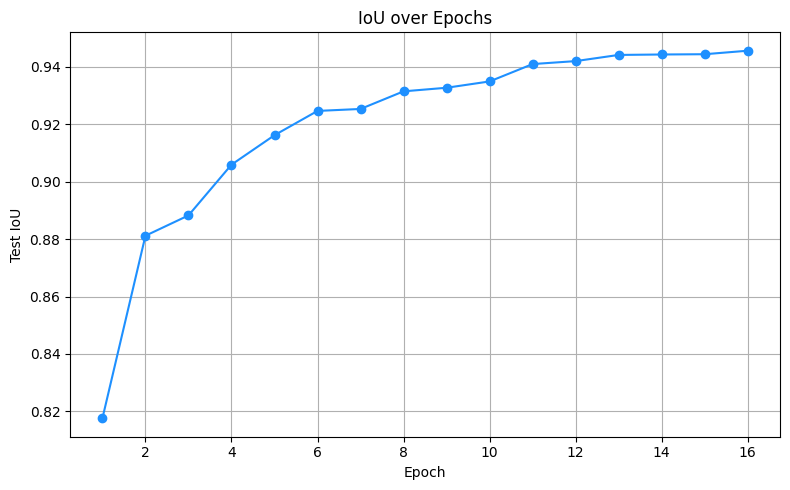

  >> Best model saved at epoch 16 with IoU: 0.9456
[10/183] Loss: 0.6763 Train Acc: 0.7681
[20/183] Loss: 0.7100 Train Acc: 0.7466
[30/183] Loss: 0.7820 Train Acc: 0.7203
[40/183] Loss: 0.8091 Train Acc: 0.7145
[50/183] Loss: 0.7759 Train Acc: 0.7141
[60/183] Loss: 0.7996 Train Acc: 0.7224
[70/183] Loss: 0.8775 Train Acc: 0.6843
[80/183] Loss: 0.8479 Train Acc: 0.7002
[90/183] Loss: 0.9287 Train Acc: 0.6715
[100/183] Loss: 0.8113 Train Acc: 0.7148
[110/183] Loss: 0.8379 Train Acc: 0.6939
[120/183] Loss: 0.8145 Train Acc: 0.7250
[130/183] Loss: 0.7527 Train Acc: 0.7386
[140/183] Loss: 0.7127 Train Acc: 0.7485
[150/183] Loss: 0.6755 Train Acc: 0.7524
[160/183] Loss: 0.7504 Train Acc: 0.7420
[170/183] Loss: 0.7233 Train Acc: 0.7529
[180/183] Loss: 0.6917 Train Acc: 0.7652
Epoch: 17, Test IoU: 0.9524


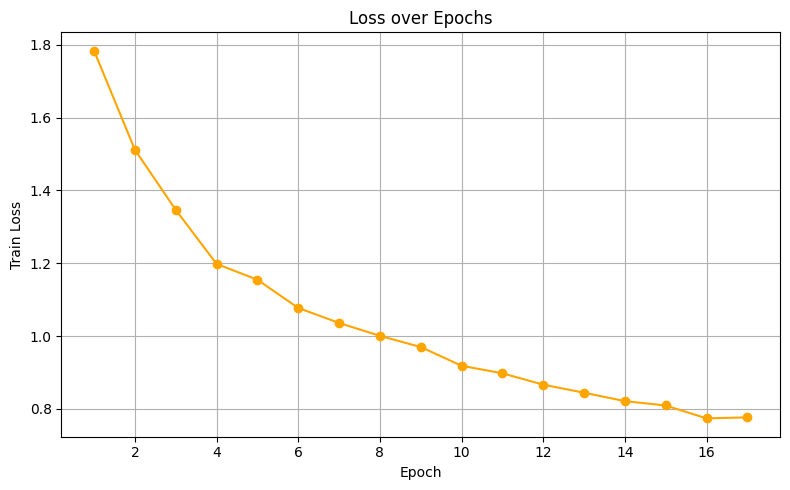

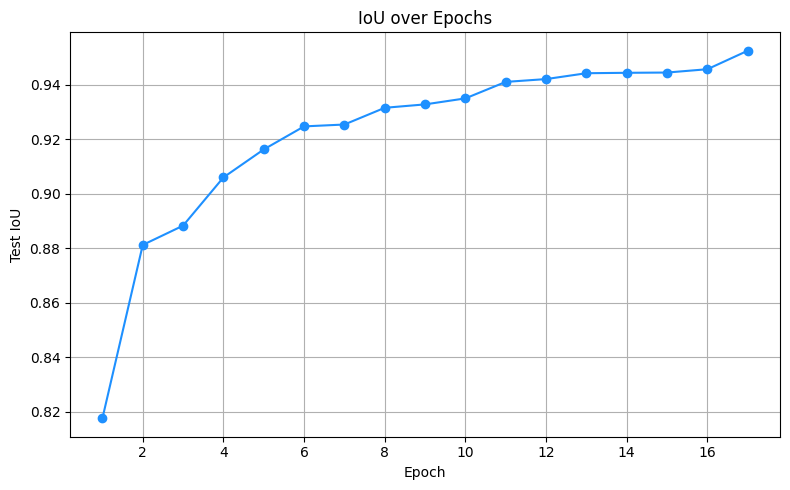

  >> Best model saved at epoch 17 with IoU: 0.9524
[10/183] Loss: 0.7659 Train Acc: 0.7393
[20/183] Loss: 0.8401 Train Acc: 0.7154
[30/183] Loss: 0.7739 Train Acc: 0.7252
[40/183] Loss: 0.7698 Train Acc: 0.7461
[50/183] Loss: 0.8337 Train Acc: 0.6863
[60/183] Loss: 0.6620 Train Acc: 0.7748
[70/183] Loss: 0.8219 Train Acc: 0.6997
[80/183] Loss: 0.7146 Train Acc: 0.7412
[90/183] Loss: 0.6764 Train Acc: 0.7644
[100/183] Loss: 0.7700 Train Acc: 0.7238
[110/183] Loss: 0.8330 Train Acc: 0.7090
[120/183] Loss: 0.7868 Train Acc: 0.7345
[130/183] Loss: 0.6984 Train Acc: 0.7469
[140/183] Loss: 0.7024 Train Acc: 0.7573
[150/183] Loss: 0.7301 Train Acc: 0.7437
[160/183] Loss: 0.7536 Train Acc: 0.7374
[170/183] Loss: 0.7593 Train Acc: 0.7321
[180/183] Loss: 0.7546 Train Acc: 0.7219
Epoch: 18, Test IoU: 0.9488


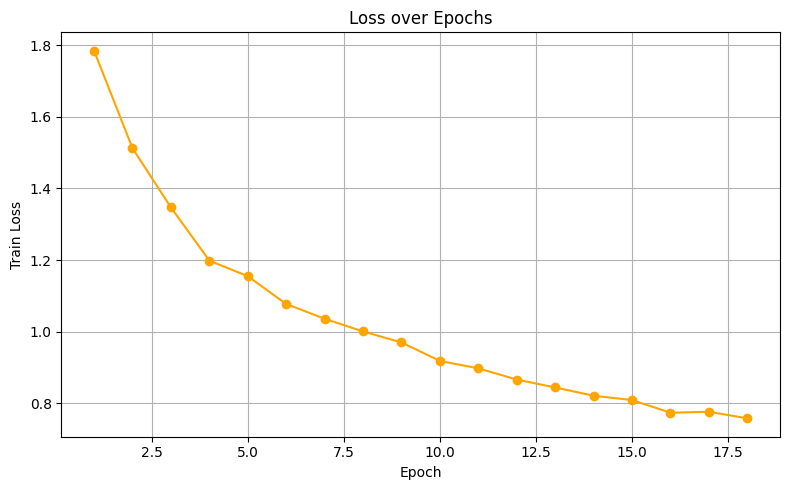

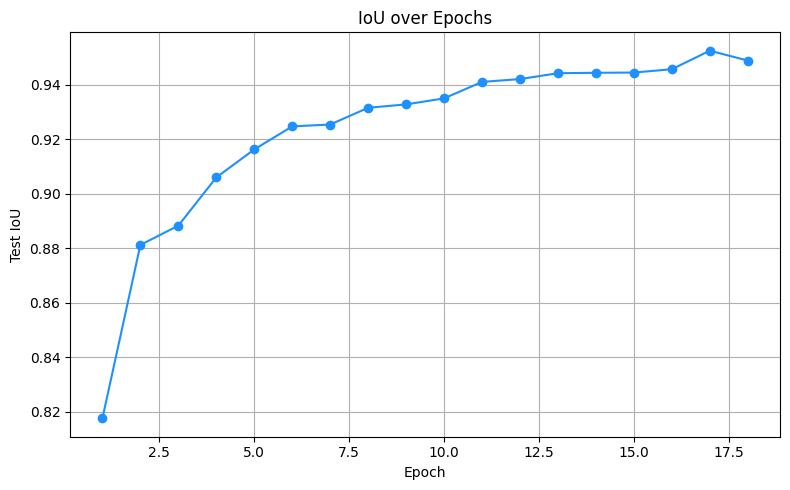

[10/183] Loss: 0.7266 Train Acc: 0.7290
[20/183] Loss: 0.7834 Train Acc: 0.7212
[30/183] Loss: 0.5772 Train Acc: 0.7903
[40/183] Loss: 0.7518 Train Acc: 0.7430
[50/183] Loss: 0.7290 Train Acc: 0.7377
[60/183] Loss: 0.6891 Train Acc: 0.7702
[70/183] Loss: 0.7469 Train Acc: 0.7293
[80/183] Loss: 0.8149 Train Acc: 0.7117
[90/183] Loss: 0.7930 Train Acc: 0.7196
[100/183] Loss: 0.6694 Train Acc: 0.7598
[110/183] Loss: 0.7200 Train Acc: 0.7526
[120/183] Loss: 0.7923 Train Acc: 0.7008
[130/183] Loss: 0.7317 Train Acc: 0.7361
[140/183] Loss: 0.7680 Train Acc: 0.7202
[150/183] Loss: 0.7703 Train Acc: 0.7306
[160/183] Loss: 0.7766 Train Acc: 0.7246
[170/183] Loss: 0.7398 Train Acc: 0.7463
[180/183] Loss: 0.7159 Train Acc: 0.7350
Epoch: 19, Test IoU: 0.9476


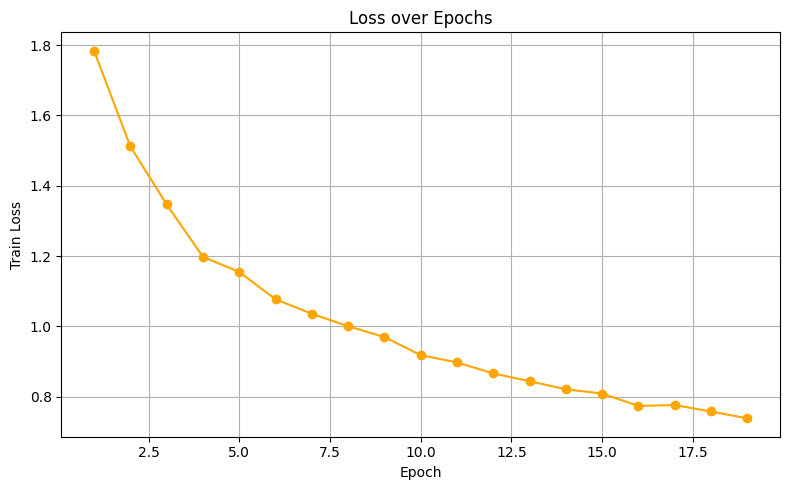

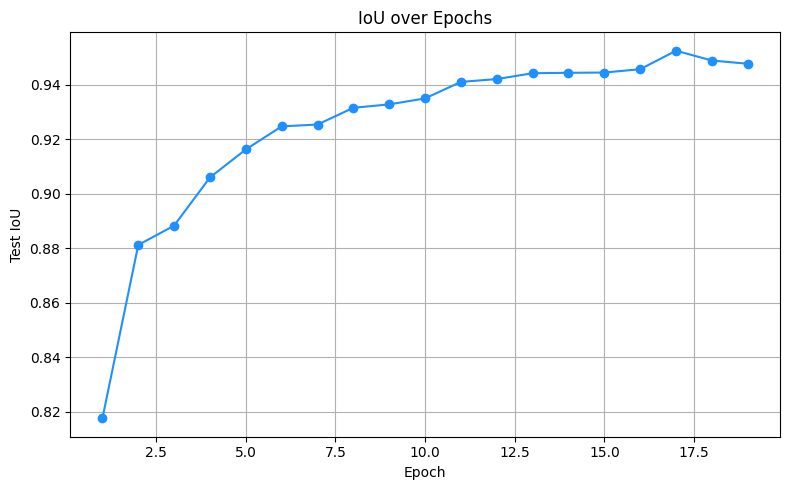

[10/183] Loss: 0.6305 Train Acc: 0.7802
[20/183] Loss: 0.6573 Train Acc: 0.7713
[30/183] Loss: 0.6860 Train Acc: 0.7612
[40/183] Loss: 0.7387 Train Acc: 0.7387
[50/183] Loss: 0.6754 Train Acc: 0.7661
[60/183] Loss: 0.7867 Train Acc: 0.7089
[70/183] Loss: 0.7349 Train Acc: 0.7360
[80/183] Loss: 0.7823 Train Acc: 0.7167
[90/183] Loss: 0.6783 Train Acc: 0.7687
[100/183] Loss: 0.6738 Train Acc: 0.7602
[110/183] Loss: 0.7038 Train Acc: 0.7528
[120/183] Loss: 0.7308 Train Acc: 0.7479
[130/183] Loss: 0.7642 Train Acc: 0.7390
[140/183] Loss: 0.7803 Train Acc: 0.7190
[150/183] Loss: 0.7467 Train Acc: 0.7431
[160/183] Loss: 0.7444 Train Acc: 0.7420
[170/183] Loss: 0.7809 Train Acc: 0.7192
[180/183] Loss: 0.7494 Train Acc: 0.7319
Epoch: 20, Test IoU: 0.9526


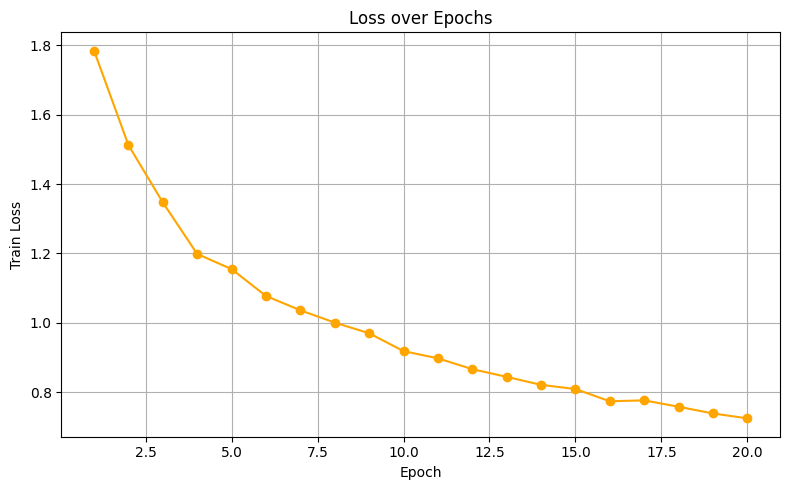

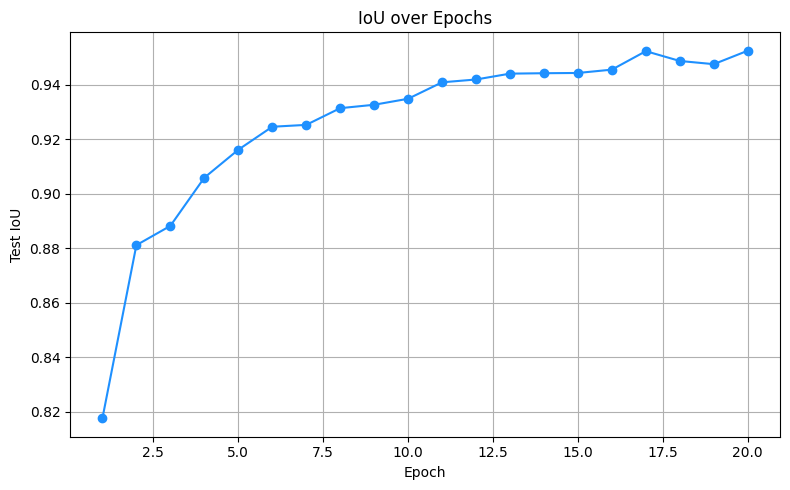

  >> Best model saved at epoch 20 with IoU: 0.9526
[10/183] Loss: 0.7537 Train Acc: 0.7148
[20/183] Loss: 0.7103 Train Acc: 0.7505
[30/183] Loss: 0.6647 Train Acc: 0.7712
[40/183] Loss: 0.7336 Train Acc: 0.7536
[50/183] Loss: 0.6862 Train Acc: 0.7625
[60/183] Loss: 0.7839 Train Acc: 0.7176
[70/183] Loss: 0.7156 Train Acc: 0.7404
[80/183] Loss: 0.6246 Train Acc: 0.7821
[90/183] Loss: 0.6800 Train Acc: 0.7585
[100/183] Loss: 0.7252 Train Acc: 0.7355
[110/183] Loss: 0.7729 Train Acc: 0.7338
[120/183] Loss: 0.7249 Train Acc: 0.7464
[130/183] Loss: 0.7335 Train Acc: 0.7460
[140/183] Loss: 0.7432 Train Acc: 0.7560
[150/183] Loss: 0.6885 Train Acc: 0.7510
[160/183] Loss: 0.6703 Train Acc: 0.7590
[170/183] Loss: 0.6666 Train Acc: 0.7645
[180/183] Loss: 0.6943 Train Acc: 0.7573
Epoch: 21, Test IoU: 0.9546


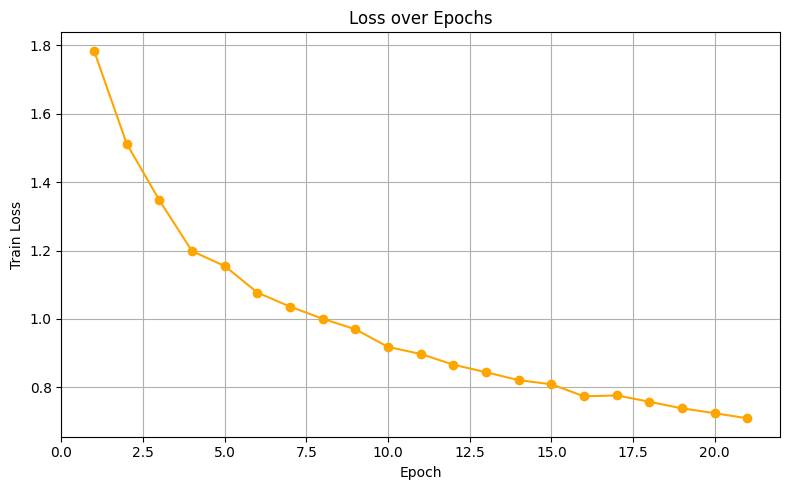

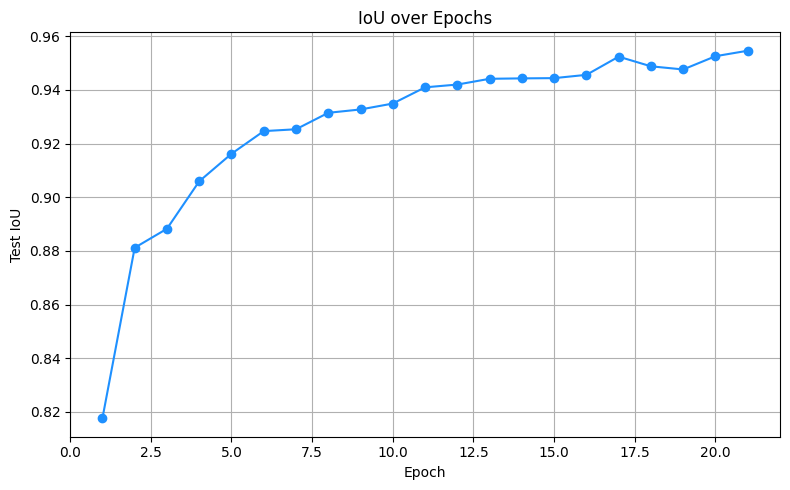

  >> Best model saved at epoch 21 with IoU: 0.9546
[10/183] Loss: 0.6480 Train Acc: 0.7787
[20/183] Loss: 0.6749 Train Acc: 0.7638
[30/183] Loss: 0.7745 Train Acc: 0.7122
[40/183] Loss: 0.6848 Train Acc: 0.7523
[50/183] Loss: 0.7063 Train Acc: 0.7519
[60/183] Loss: 0.6264 Train Acc: 0.7841
[70/183] Loss: 0.6812 Train Acc: 0.7643
[80/183] Loss: 0.6963 Train Acc: 0.7520
[90/183] Loss: 0.7926 Train Acc: 0.7144
[100/183] Loss: 0.7256 Train Acc: 0.7427
[110/183] Loss: 0.6749 Train Acc: 0.7650
[120/183] Loss: 0.6169 Train Acc: 0.7863
[130/183] Loss: 0.7053 Train Acc: 0.7509


KeyboardInterrupt: 

In [14]:
%%time

import matplotlib.pyplot as plt

def train():
    model.train()
    loss_list = []
    acc_list = []
    total_loss = correct_nodes = total_nodes = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes

        if (i + 1) % 10 == 0:
            tloss = total_loss / 10
            tacc = correct_nodes / total_nodes
            print(f'[{i+1}/{len(train_loader)}] Loss: {tloss:.4f} '
                  f'Train Acc: {tacc:.4f}')
            total_loss = correct_nodes = total_nodes = 0
            loss_list.append(tloss)
            acc_list.append(tacc)

    return np.mean(loss_list), np.mean(acc_list)

@torch.no_grad()
def test(loader):
    model.eval()

    ious, categories = [], []
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)


            iou = jaccard_index(out[:, part].argmax(dim=-1), y_map[y],
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)
        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    return float(mean_iou.mean())  # Global IoU.

def plot_iou_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='dodgerblue')
    plt.title('IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test IoU')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

iou_list = []
loss_list = []

best_iou = 0.0  # or float('-inf') if you're maximizing
best_model_path = "dgcnn.pth"

for epoch in range(1, 51):
    loss, acc = train()
    loss_list.append(loss)
    iou = test(test_loader)
    iou_list.append(iou)
    print(f'Epoch: {epoch:02d}, Test IoU: {iou:.4f}')
    plot_loss_over_epochs(loss_list)
    plot_iou_over_epochs(iou_list)
    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), best_model_path)
        print(f"  >> Best model saved at epoch {epoch} with IoU: {best_iou:.4f}")





In [15]:
print(max(iou_list))


0.9546192288398743


#Test


In [16]:
model.load_state_dict(torch.load("/content/dgcnn.pth"))

<All keys matched successfully>

In [20]:
import os
import numpy as np
from pathlib import Path

@torch.no_grad()
def predict_and_save_per_sample(loader, output_dir="break_results"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    idx = 0  # sample index

    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)  # assume input is point positions

        ys = data.y.split(sizes)
        categories = data.category.tolist()

        for x, out, y, category in zip(xs, outs.split(sizes), ys, categories):
            category_str = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category_str]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            y_pred = out[:, part].argmax(dim=-1)
            y_true = y_map[y]

            # Save as npz
            file_path = Path(output_dir) / f"sample_{idx:04d}.npz"
            np.savez_compressed(
                file_path,
                x=x.cpu().numpy(),             # 3D points
                y_true=y_true.cpu().numpy(),   # ground truth labels
                y_pred=y_pred.cpu().numpy()    # predicted labels
            )
            idx += 1

    print(f"Saved {idx} samples to: {output_dir}")
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])
pred_cmap = np.array([
    [0.054, 0.705, 0.054],  # Blue
    [1.000, 0.498, 0.054],  # Orange
])

def visualize_sample_npz(file_path):
    data = np.load(file_path)
    x = data['x']           # shape: (N, 3)
    y_true = data['y_true'] # shape: (N,)
    print(np.unique(y_true))
    y_pred = data['y_pred'] # shape: (N,)
    print(np.unique(y_pred))

    gt_colors = gt_cmap[y_true]
    pred_colors = pred_cmap[y_pred]

    fig = plt.figure(figsize=(12, 6))

    # --- Ground Truth ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], x[:, 2], c=gt_colors, s=5)
    ax1.set_title("Ground Truth Labels")
    ax1.axis('off')

    # --- Prediction ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], x[:, 2], c=pred_colors, s=5)
    ax2.set_title("Predicted Labels")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()




In [19]:

@torch.no_grad()
def eval_value(loader):
    model.eval()

    ious, categories = [], []
    correct, total = 0, 0  # For accuracy
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()

    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            pred = out[:, part].argmax(dim=-1)
            target = y_map[y]

            correct += (pred == target).sum().item()
            total += target.numel()

            iou = jaccard_index(pred, target,
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)

        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    accuracy = correct / total

    return accuracy, float(mean_iou.mean())  # Return both Accuracy and Mean IoU

In [21]:
acc, miou = eval_value(test_loader)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.9848, Mean IoU: 0.9546


In [22]:
predict_and_save_per_sample(test_loader)

Saved 549 samples to: break_results


Sample_0517.npz
[0 1]
[0 1]


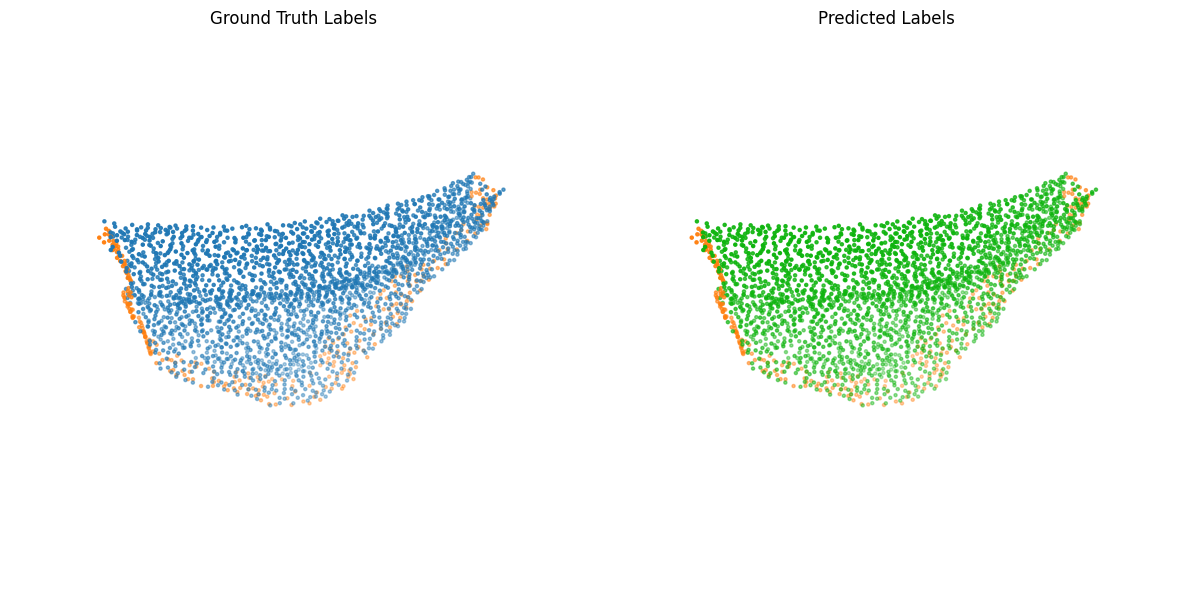

In [34]:
idx = random.randint(0, 549)
print(f"Sample_{idx:04d}.npz")
visualize_sample_npz(f"/content/break_results/sample_{idx:04d}.npz")

#fanta


In [36]:
!unzip /content/processed_fanta_1_obj.zip -d /content/temp_extract
!mkdir /content/data2
!mkdir /content/data2/raw
!mv /content/temp_extract/processed_fanta_1_obj/* /content/data2/raw
!rm -r /content/temp_extract

Archive:  /content/processed_fanta_1_obj.zip
   creating: /content/temp_extract/processed_fanta_1_obj/
   creating: /content/temp_extract/processed_fanta_1_obj/abc/
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00002.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00003.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00005.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00006.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00008.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00011.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00012.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00013.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00014.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00015.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00016.txt  
  inflating: /content/temp_extra

In [37]:

class FantaBrk(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {'All_Statue': 'abc'}



    seg_classes = {'All_Statue': [0, 1]}

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {'abc': 0}
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [38]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data2"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset2 = FantaBrk(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset2 = FantaBrk(path, category, split='test',
                        pre_transform=pre_transform)
train_loader2 = DataLoader(train_dataset2, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader2 = DataLoader(test_dataset2, batch_size=12, shuffle=False,
                         num_workers=2)

['All_Statue']


Processing...


['All_Statue']


Done!


Unique classes [0 1]


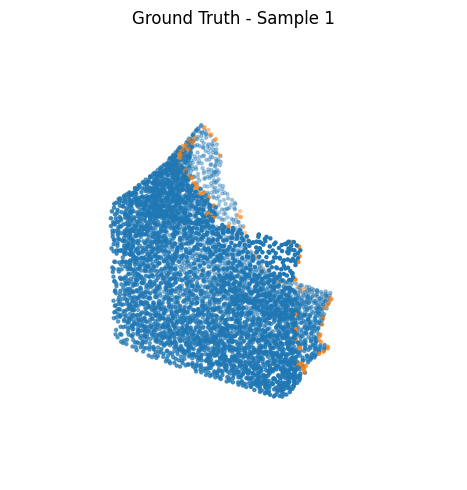

Unique classes [0 1]


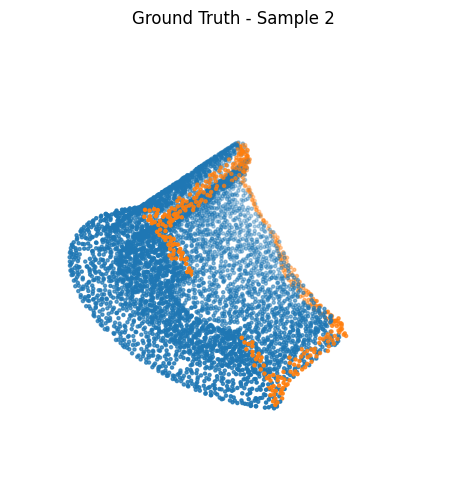

Unique classes [0 1]


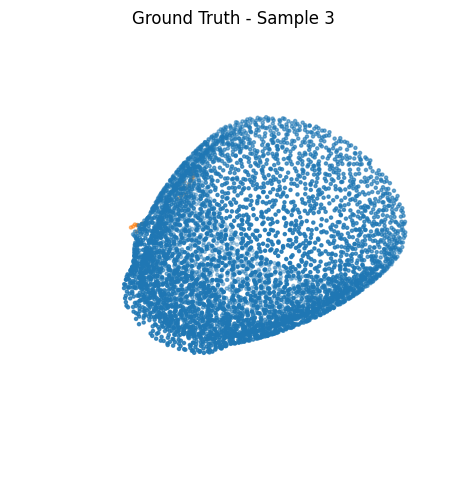

Unique classes [0 1]


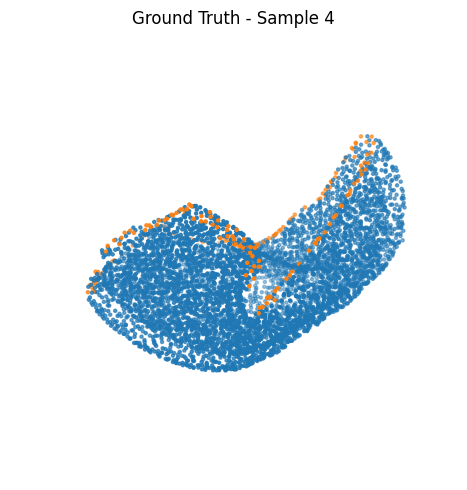

In [39]:
visualize_ground_truth_3d(test_loader2, num_samples=4)

In [40]:
acc, miou = eval_value(train_loader2)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.7727, Mean IoU: 0.3961


In [41]:
length = predict_and_save_per_sample(train_loader2,output_dir = "fanta_result")

Saved 120 samples to: fanta_result


Sample_0103.npz
[0 1]
[0 1]


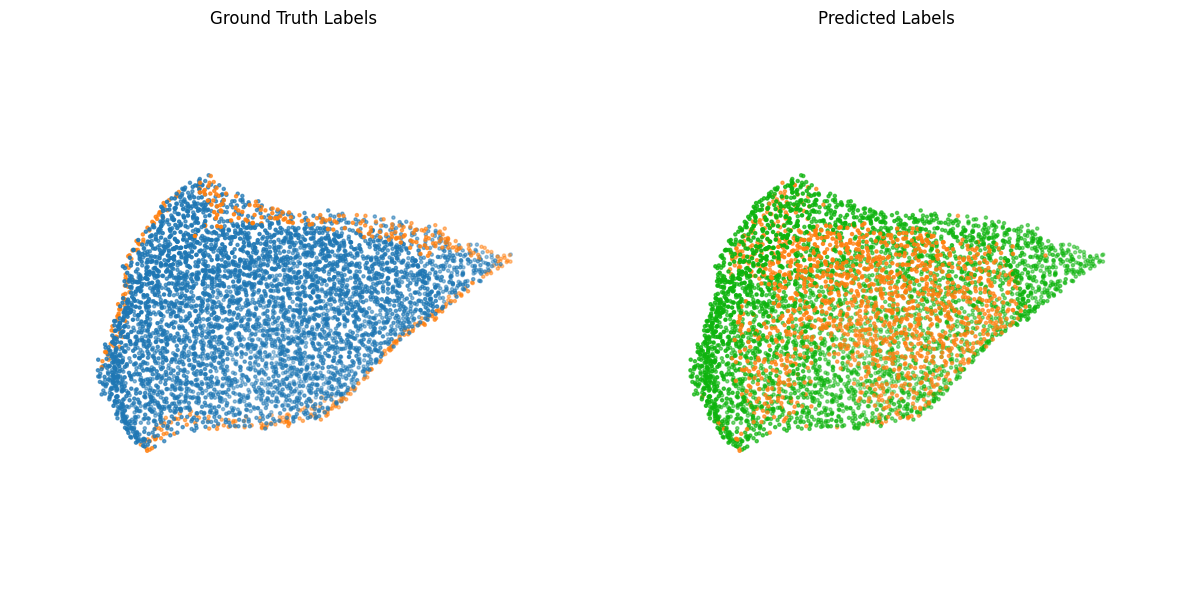

Sample_0000.npz
[0 1]
[0 1]


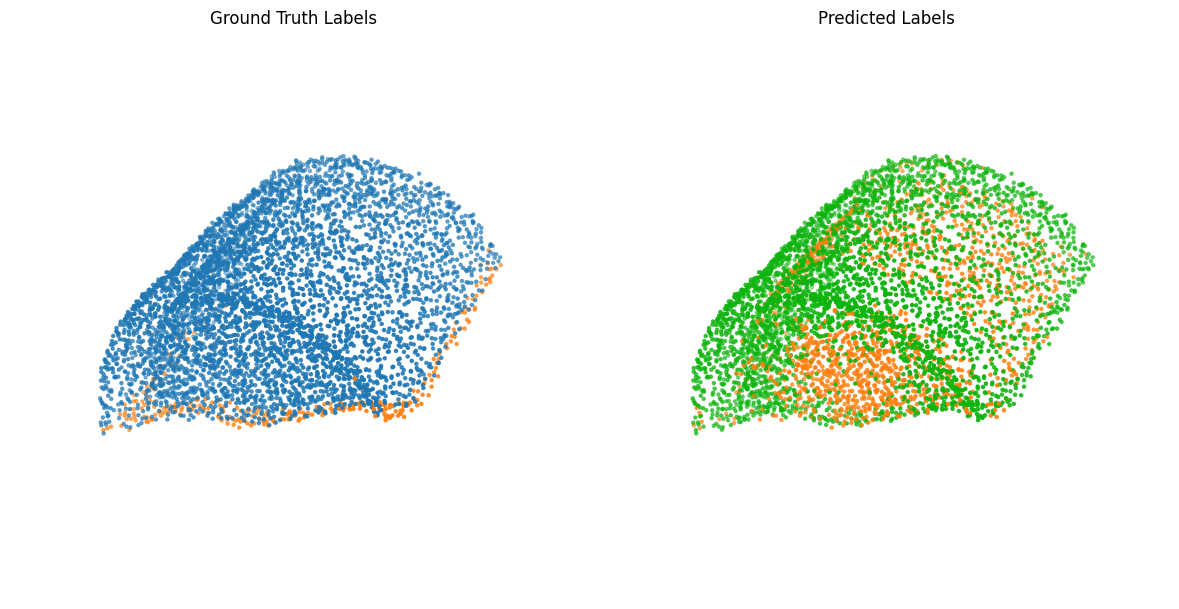

Sample_0050.npz
[0 1]
[0 1]


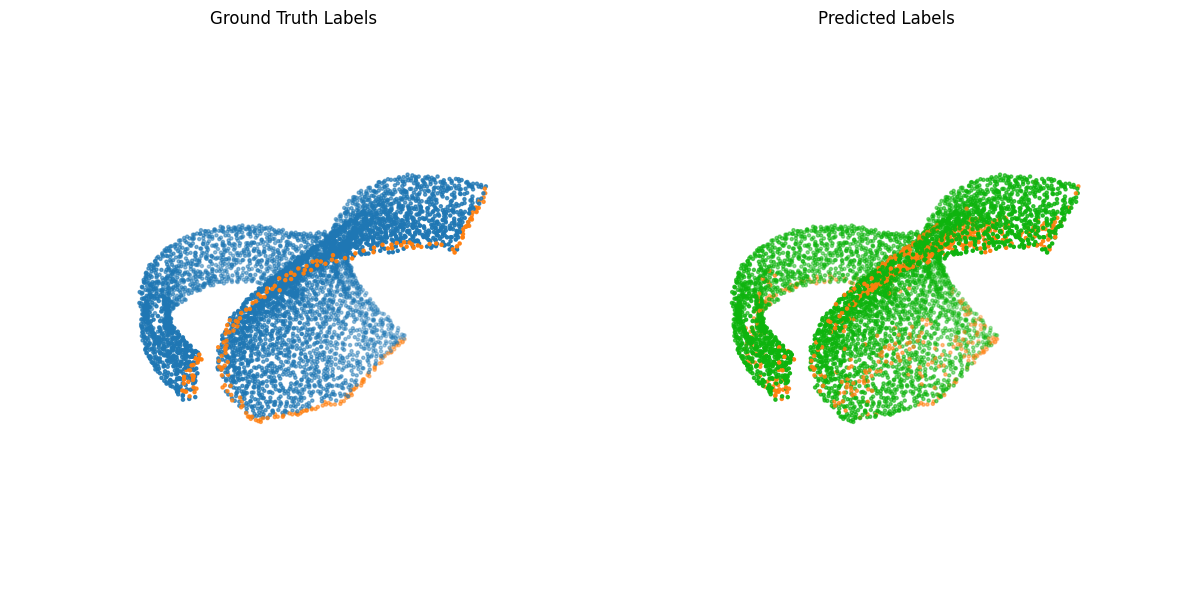

Sample_0061.npz
[0 1]
[0 1]


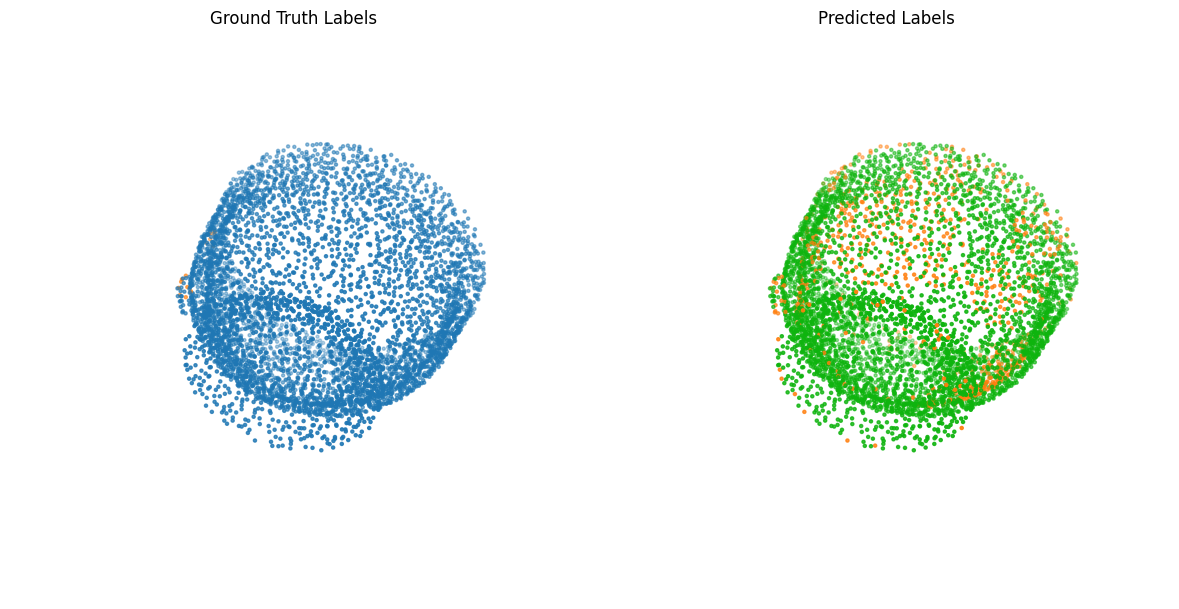

Sample_0090.npz
[0 1]
[0 1]


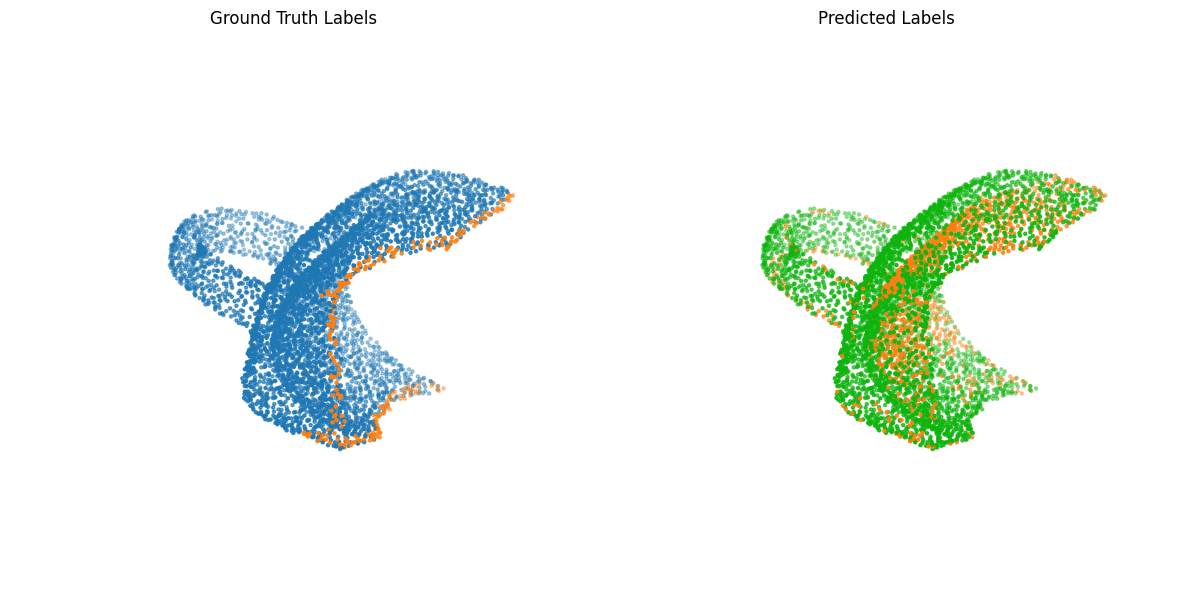

In [43]:
def wow2():
  idx = random.randint(0, 120)
  print(f"Sample_{idx:04d}.npz")
  visualize_sample_npz(f"/content/fanta_result/sample_{idx:04d}.npz")

wow2()

wow2()

wow2()
wow2()

wow2()

In [44]:
!mkdir -p output
!cp -r /content/break_result output/
!cp -r /content/fanta_result output/
!cp /content/dgcnn.pth output/
!zip -r DGCNN.zip output

from google.colab import files
files.download("DGCNN.zip")

  adding: output/ (stored 0%)
  adding: output/break_result/ (stored 0%)
  adding: output/break_result/sample_0463.npz (deflated 0%)
  adding: output/break_result/sample_0200.npz (deflated 0%)
  adding: output/break_result/sample_0333.npz (deflated 0%)
  adding: output/break_result/sample_0510.npz (deflated 0%)
  adding: output/break_result/sample_0210.npz (deflated 0%)
  adding: output/break_result/sample_0270.npz (deflated 0%)
  adding: output/break_result/sample_0344.npz (deflated 0%)
  adding: output/break_result/sample_0322.npz (deflated 0%)
  adding: output/break_result/sample_0230.npz (deflated 1%)
  adding: output/break_result/sample_0172.npz (deflated 1%)
  adding: output/break_result/sample_0308.npz (deflated 0%)
  adding: output/break_result/sample_0125.npz (deflated 1%)
  adding: output/break_result/sample_0394.npz (deflated 0%)
  adding: output/break_result/sample_0195.npz (deflated 0%)
  adding: output/break_result/sample_0260.npz (deflated 0%)
  adding: output/break_resu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>